<a href="https://colab.research.google.com/github/carlogalli/colab-gpu/blob/main/reducedform_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [4]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

After you run the first cell (the cell directly above this text), go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.7* in Runtime type. You can also select your prefered harwdware acceleration (defaults to GPU).

In [1]:
VERSION   # print Julia version

v"1.7.2"

In [ ]:
using Pkg
Pkg.add(["CUDA", "Random", "Distributions", "Printf", "PyPlot", "PrettyTables", "Adapt", "DataFrames", "CSV", "Interpolations"]);
ENV["JULIA_CUDA_USE_BINARYBUILDER"] = false
using Random, Distributions, CUDA, Printf, PyPlot, PrettyTables, Adapt, DataFrames, CSV, Interpolations;

function print_gpu_properties()

    for (i,device) in enumerate(CUDA.devices())
        println("*** General properties for device $i ***")
        name = CUDA.name(device)
        println("Device name: $name")
        major = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MAJOR)
        minor = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MINOR)
        println("Compute capabilities: $major.$minor")
        clock_rate = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_CLOCK_RATE)
        println("Clock rate: $clock_rate")
        device_overlap = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_GPU_OVERLAP)
        print("Device copy overlap: ")
        println(device_overlap > 0 ? "enabled" : "disabled")
        kernel_exec_timeout = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_KERNEL_EXEC_TIMEOUT)
        print("Kernel execution timeout: ")
        println(kernel_exec_timeout > 0 ? "enabled" : "disabled")
        # a = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X)
        # d = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X)       
        a = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT)
        println("Number of multiprocessors: $a")
        b = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MAX_BLOCKS_PER_MULTIPROCESSOR)
        println("Max blocks per MP: $b")
        c = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)        
        println("Max threads per block: $c")
        
        println([a b c a*b*c])
    end
end
print_gpu_properties()
# with the falseENV option it takes 117.357304 seconds (35.94 M allocations: 2.301 GiB, 1.29% gc time, 11.71% compilation time)
# without the falseENV option it takes  124.465413 seconds (39.74 M allocations: 2.537 GiB, 1.27% gc time, 12.65% compilation time)


#Pkg.add("CpuId")
#using CpuId
#cpuinfo()

# JMP functions

In [3]:
#= FUNCTIONS =#

CUDA.allowscalar(false)

# Model Parameters
struct ModelParams
    # Array Parameters
    nb::Int32
    ny::Int32
    T_longterm::Int32
    T_sim::Int32
    T_discard_sim::Int32
    bgrid_lb::Float32
    bgrid_ub::Float32

    # Model Parameters
    σ_c::Float32    # c risk aversion
    σ_g::Float32    # g risk aversion
    g_lb::Float32   # g lower bound
    η::Float32      # inflation cost curvature
    r::Float32      # intnl risk-free rate
    ρ::Float32      # income process persistence
    σ_ϵ::Float32    # income process error standard deviation
    θ::Float32      # ree-enter probability
    h::Float32      # haircut on debt
    
    β::Float32      # df govt
    α_g::Float32    # spending utility weight
    α_m::Float32    # inflation cost in repayment
    ϕ_m::Float32      # inflation cost in default
    ζ_m::Float32      # exponent of output component of inflation cost
    κ_seign::Float32    # seignorage constant
    ζ_seign::Float32    # seignorage output exponent
    τbar::Float32

    d0::Float32     # linear coefficient on default costadd C
    d1::Float32     # quadratic coefficient on default cost
    λ::Float32      # debt maturity
    κ::Float32      # debt coupon
    ρ_B::Float32    # coefficient of Gumbel debt taste shocks
    ρ_μ::Float32    # coefficient of Gumbel mu_D taste shocks
    ρ_δ::Float32    # coefficient of Gumbel default taste shocks

    gpu::Bool
end
function build_ModelParams(;
        nb=51, ny=21, T_longterm=20, T_sim=10^6, T_discard_sim=10^3, bgrid_lb=1e-2, bgrid_ub=2.5,
        σ_c=2., σ_g=2., g_lb=0., η=2., r=0.00598, ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37,
        β=.95, α_g=0.07, α_m=1., ϕ_m=1., ζ_m=0., κ_seign=0., ζ_seign=0., τbar=0.99,
        d0=-0.4, d1=0.43, λ=1., κ=0., 
        ρ_B=1e-10, ρ_μ=1e-10, ρ_δ=1e-10,
        gpu=true
    )

    return ModelParams(
        nb, ny, T_longterm, T_sim, T_discard_sim, bgrid_lb, bgrid_ub,
        σ_c, σ_g, g_lb, η, r, ρ, σ_ϵ, θ, h, 
        β, α_g, α_m, ϕ_m, ζ_m, κ_seign, ζ_seign, τbar,
        d0, d1, λ, κ, 
        ρ_B, ρ_μ, ρ_δ, 
        gpu
    )
end

# Model Arrays
struct ModelArrays{V,A}
    bgrid::V
    ygrid::V
    P::A
    
    v0::A
    v::A
    ev::A
    evd::A
    def_policy::A

    vr::A
    c_rep::A
    g_rep::A
    τ_rep::A
    Π_rep::A
    bprime_rep::A
    q_rep::A
    qfuture_rep::A

    vd::A
    c_def::A
    g_def::A
    τ_def::A
    Π_def::A
    bprime_def::A
    q_def::A
    qfuture_def::A
end
function build_ModelArrays(mp::ModelParams)
    # Bond grid
    bgrid = collect(range(mp.bgrid_lb, stop=mp.bgrid_ub, length=mp.nb))

    # Endowment grid and transition probs
    grid, P = tauchen_carlo(mp.ny, mp.ρ, mp.σ_ϵ)
    ygrid = exp.(grid)

    yh = ygrid[end]
    if 1-mp.d0-mp.d1*2*yh < 0
        error("default costs make yd decreasing in y")
    end

    if mp.gpu
        bgrid = CuArray(bgrid)
        ygrid = CuArray(ygrid)
        P = CuArray(P)
        v0, v, ev, evd, def_policy = [CUDA.zeros(mp.nb, mp.ny) for i in 1:5]
        vr, c_rep, g_rep, τ_rep, Π_rep, bprime_rep, q_rep, qfuture_rep = [CUDA.zeros(mp.nb, mp.ny) for i in 1:8]
        vd, c_def, g_def, τ_def, Π_def, bprime_def, q_def, qfuture_def = [CUDA.zeros(mp.nb, mp.ny) for i in 1:8]
    else
        v0, v, ev, evd, def_policy = [zeros(Float32, mp.nb, mp.ny) for i in 1:5]
        vr, c_rep, g_rep, τ_rep, Π_rep, bprime_rep, q_rep, qfuture_rep = [zeros(Float32, mp.nb, mp.ny) for i in 1:8]
        vd, c_def, g_def, τ_def, Π_def, bprime_def, q_def, qfuture_def = [zeros(Float32, mp.nb, mp.ny) for i in 1:8]
    end

    return ModelArrays(
        bgrid, ygrid, P,
        v0, v, ev, evd, def_policy,
        vr, c_rep, g_rep, τ_rep, Π_rep, bprime_rep, q_rep, qfuture_rep,
        vd, c_def, g_def, τ_def, Π_def, bprime_def, q_def, qfuture_def
    )
end
function Adapt.adapt_structure(to, model::ModelArrays)
    bgrid = Adapt.adapt_structure(to, model.bgrid)
    ygrid = Adapt.adapt_structure(to, model.ygrid)
    P = Adapt.adapt_structure(to, model.P)

    v0 = Adapt.adapt_structure(to, model.v0)
    v = Adapt.adapt_structure(to, model.v)
    ev = Adapt.adapt_structure(to, model.ev)
    evd = Adapt.adapt_structure(to, model.evd)
    def_policy = Adapt.adapt_structure(to, model.def_policy)
    
    vr = Adapt.adapt_structure(to, model.vr)
    c_rep = Adapt.adapt_structure(to, model.c_rep)
    g_rep = Adapt.adapt_structure(to, model.g_rep)
    τ_rep = Adapt.adapt_structure(to, model.τ_rep)
    Π_rep = Adapt.adapt_structure(to, model.Π_rep)
    bprime_rep = Adapt.adapt_structure(to, model.bprime_rep)
    q_rep = Adapt.adapt_structure(to, model.q_rep)
    qfuture_rep = Adapt.adapt_structure(to, model.qfuture_rep)

    vd = Adapt.adapt_structure(to, model.vd)
    c_def = Adapt.adapt_structure(to, model.c_def)
    g_def = Adapt.adapt_structure(to, model.g_def)
    τ_def = Adapt.adapt_structure(to, model.τ_def)
    Π_def = Adapt.adapt_structure(to, model.Π_def)
    bprime_def = Adapt.adapt_structure(to, model.bprime_def)
    q_def = Adapt.adapt_structure(to, model.q_def)
    qfuture_def = Adapt.adapt_structure(to, model.qfuture_def)

    ModelArrays(
        bgrid, ygrid, P,
        v0, v, ev, evd, def_policy,
        vr, c_rep, g_rep, τ_rep, Π_rep, bprime_rep, q_rep, qfuture_rep,
        vd, c_def, g_def, τ_def, Π_def, bprime_def, q_def, qfuture_def
    )
end

# Model Arrays (temporary)
struct ModelArraysTemp{A}
    vs_rep::A
    cs_rep::A
    Πs_rep::A
    cps_rep::A
    vs_def::A
    cs_def::A
    cps_def::A
end
function build_ModelArraysTemp(mp::ModelParams)
    if mp.gpu
        vs_rep, cs_rep, Πs_rep, cps_rep, vs_def, cs_def, cps_def = [CUDA.zeros(mp.nb, mp.ny, mp.nb) for i in 1:7]
    else
        vs_rep, cs_rep, Πs_rep, cps_rep, vs_def, cs_def, cps_def = [zeros(Float32, mp.nb, mp.ny, mp.nb) for i in 1:7]
    end
    
    return ModelArraysTemp(
        vs_rep, cs_rep, Πs_rep, cps_rep, vs_def, cs_def, cps_def
    )
end
function Adapt.adapt_structure(to, model::ModelArraysTemp)
    vs_rep = Adapt.adapt_structure(to, model.vs_rep)
    cs_rep = Adapt.adapt_structure(to, model.cs_rep)
    Πs_rep = Adapt.adapt_structure(to, model.Πs_rep)
    cps_rep = Adapt.adapt_structure(to, model.cps_rep)
    vs_def = Adapt.adapt_structure(to, model.vs_def)
    cs_def = Adapt.adapt_structure(to, model.cs_def)
    cps_def = Adapt.adapt_structure(to, model.cps_def)

    ModelArraysTemp(
        vs_rep, cs_rep, Πs_rep, cps_rep, vs_def, cs_def, cps_def
    )
end

# Equilibrium Prices
struct PricesEqm{A}
    expdef_short_eqm_rep::A
    expdef_long_eqm_rep::A
    expinf_short_eqm_rep::A
    expinf_long_eqm_rep::A
    expinf_long_eqm_def::A
end
function build_PricesEqm(mp::ModelParams)
    if mp.gpu
        expdef_short_eqm_rep, expdef_long_eqm_rep = [CUDA.zeros(Float32, mp.nb, mp.ny) for i in 1:2]
        expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def = [CUDA.ones(Float32, mp.nb, mp.ny) for i in 1:3]
    else
        expdef_short_eqm_rep, expdef_long_eqm_rep = [zeros(Float32, mp.nb, mp.ny) for i in 1:2]
        expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def = [ones(Float32, mp.nb, mp.ny) for i in 1:3]
    end
    
    return PricesEqm(
        expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def
    )
end
function Adapt.adapt_structure(to, model::PricesEqm)
    expdef_short_eqm_rep = Adapt.adapt_structure(to, model.expdef_short_eqm_rep)
    expdef_long_eqm_rep = Adapt.adapt_structure(to, model.expdef_long_eqm_rep)
    expinf_short_eqm_rep = Adapt.adapt_structure(to, model.expinf_short_eqm_rep)
    expinf_long_eqm_rep = Adapt.adapt_structure(to, model.expinf_long_eqm_rep)
    expinf_long_eqm_def = Adapt.adapt_structure(to, model.expinf_long_eqm_def)

    PricesEqm(
        expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def
    )
end

# Future Prices
struct PricesFuture{A}
    expdef_short_future_rep::A
    expdef_long_future_rep::A
    expinf_short_future_rep::A
    expinf_long_future_rep::A
    expinf_long_future_def::A
end
function build_PricesFuture(mp::ModelParams)
    if mp.gpu
        expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def = [CUDA.zeros(Float32, mp.nb, mp.ny) for i in 1:5]
    else
        expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def = [zeros(Float32, mp.nb, mp.ny) for i in 1:5]
    end

    return PricesFuture(
        expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def
    )
end
function Adapt.adapt_structure(to, model::PricesFuture)
    expdef_short_future_rep = Adapt.adapt_structure(to, model.expdef_short_future_rep)
    expdef_long_future_rep = Adapt.adapt_structure(to, model.expdef_long_future_rep)
    expinf_short_future_rep = Adapt.adapt_structure(to, model.expinf_short_future_rep)
    expinf_long_future_rep = Adapt.adapt_structure(to, model.expinf_long_future_rep)
    expinf_long_future_def = Adapt.adapt_structure(to, model.expinf_long_future_def)

    PricesFuture(
        expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def
    )
end

# Simulation Arrays
struct SimulationArrays{Vfloat, Vbool, Vint}
    y_sim::Vfloat
    b_sim::Vfloat
    q_sim::Vfloat
    Π_qoq_sim::Vfloat
    Π_yoy_sim::Vfloat
    c_sim::Vfloat
    g_sim::Vfloat

    def_status::Vbool
    def_new::Vbool
    
    b_sim_indices::Vint
    y_sim_indices::Vint

    taste_errors::Vfloat
end
function build_SimulationArrays(mp::ModelParams)
    y_sim, b_sim, q_sim, Π_qoq_sim, c_sim, g_sim = [zeros(Float32, mp.T_sim) for i in 1:6]
    Π_yoy_sim = ones(Float32, mp.T_sim)
    def_status, def_new = [zeros(Bool, mp.T_sim) for i in 1:2]
    b_sim_indices, y_sim_indices = [zeros(Int32, mp.T_sim) for i in 1:2]
    taste_errors = zeros(Float32, 3)

    return SimulationArrays(
        y_sim, b_sim, q_sim, Π_qoq_sim, Π_yoy_sim, c_sim, g_sim,
        def_status, def_new,
        b_sim_indices, y_sim_indices, 
        taste_errors
    )
end
function Adapt.adapt_structure(to, model::SimulationArrays)
    y_sim = Adapt.adapt_structure(to, model.y_sim)
    b_sim = Adapt.adapt_structure(to, model.b_sim)
    q_sim = Adapt.adapt_structure(to, model.q_sim)
    Π_qoq_sim = Adapt.adapt_structure(to, model.Π_qoq_sim)
    Π_yoy_sim = Adapt.adapt_structure(to, model.Π_yoy_sim)
    c_sim = Adapt.adapt_structure(to, model.c_sim)
    g_sim = Adapt.adapt_structure(to, model.g_sim)

    def_status = Adapt.adapt_structure(to, model.def_status)
    def_new = Adapt.adapt_structure(to, model.def_new)
    
    b_sim_indices = Adapt.adapt_structure(to, model.b_sim_indices)
    y_sim_indices = Adapt.adapt_structure(to, model.y_sim_indices)
    taste_errors = Adapt.adapt_structure(to, model.taste_errors)

    SimulationArrays(
        y_sim, b_sim, q_sim, Π_qoq_sim, Π_yoy_sim, c_sim,
        def_status, def_new,
        b_sim_indices, y_sim_indices, 
        taste_errors
    )
end

# Simulation Prices
struct SimulationPrices{V}
    expdef_short_sim::V
    expdef_long_sim::V
    expinf_short_sim::V
    expinf_long_sim::V
end
function build_SimulationPrices(mp::ModelParams)
    expdef_short_sim, expdef_long_sim, expinf_short_sim, expinf_long_sim = [zeros(Float32, mp.T_sim) for i in 1:4]

    return SimulationPrices(
        expdef_short_sim, expdef_long_sim, expinf_short_sim, expinf_long_sim
    )
end
function Adapt.adapt_structure(to, model::SimulationPrices)
    expdef_short_sim = Adapt.adapt_structure(to, model.expdef_short_sim)
    expdef_long_sim = Adapt.adapt_structure(to, model.expdef_long_sim)
    expinf_short_sim = Adapt.adapt_structure(to, model.expinf_short_sim)
    expinf_long_sim = Adapt.adapt_structure(to, model.expinf_long_sim)

    SimulationPrices(
        expdef_short_sim, expdef_long_sim, expinf_short_sim, expinf_long_sim
    )
end

# Functions
function tauchen_carlo(N::Int32, ρ::Float32, σ_ϵ::Float32; μ::Real=0, n_std::Real=4)

    # process (x_t above) standard deviation (std is ϵ's standard deviation)
    σ_y = σ_ϵ/sqrt(1-ρ^2)
    grid_bar = n_std * σ_y      # grid bounds
    grid = collect(Float32, range(μ-grid_bar, stop=μ+grid_bar, length=N))
    dif = grid[2]-grid[1]
  
    # Get transition probabilities
    P = zeros(Float32, N, N)
    
    # return nothing

    for row in 1:N
        
        # do endpoints first
        P[row, 1] = cdf(Normal(0., 1.), (grid[1]+dif/2 -(1-ρ)*μ -ρ*grid[row])/σ_ϵ )
        P[row, N] = 1-cdf(Normal(0., 1.), (grid[N]-dif/2 -(1-ρ)*μ -ρ*grid[row])/σ_ϵ )

        # middle columns
        for col in 2:N-1
            P[row, col] = cdf(Normal(0., 1.), (grid[col]+dif/2 -(1-ρ)*μ -ρ*grid[row])/σ_ϵ ) - cdf(Normal(0., 1.), (grid[col]-dif/2 -(1-ρ)*μ -ρ*grid[row])/σ_ϵ )
        end
    end

    # normalize
    sums = sum(P, dims=2)    

    P = @. P/sums
    
    if maximum(abs.(sum(P, dims=2).-1)) > 1e-6
        error("Matrix rows must sum up to 1!")
    end
  
    return grid, P
end

function u_typed_fn(mp::ModelParams, c::Float32, g::Float32, Π::Float32, y::Float32)
    return (c^(1f0-mp.σ_c))/(1f0-mp.σ_c) + mp.α_g*((g-mp.g_lb)^(1f0-mp.σ_g))/(1-mp.σ_g) - mp.α_m*(y^mp.ζ_m)*(Π-1f0)^mp.η
end

function ydef_fn(mp::ModelParams, y::Float32)
    return y - max(0, mp.d0*y + mp.d1*y^2)

    #σ_y = mp.σ_ϵ/sqrt(1-mp.ρ^2)
    #yub = exp(4f0 * σ_y)
    #y1 = -mp.d0/mp.d1
    #y2 =  yub - max(0, mp.d0*yub + mp.d1*yub^2)
    #coef = (y2-y1)/(yub-y1)
    #interc = y1*(1-coef)
    #return min(y, interc + coef*y)
end

function my_dot_product(xvec, yvec)
    temp = Float32(0)
    for i in 1:lastindex(xvec)
        temp += xvec[i]*yvec[i]
    end
    return temp
end

function my_brent(
    f::Function , x_lower::Float32, x_upper::Float32;
    rel_tol::Float32 = sqrt(eps(Float32)),
    abs_tol::Float32 = eps(Float32),
    iterations::Int32 = Int32(1000),
    my_trace::Bool = false)


    if x_lower > x_upper
        error("x_lower must be less than x_upper")
    end

    golden_ratio = Float32(1)/2 * (3 - sqrt(Float32(5.0)))

    new_minimizer = x_lower + golden_ratio*(x_upper-x_lower)
    new_minimum = f(new_minimizer)
    best_bound = "initial"
    f_calls = 1 # Number of calls to f
    step = zero(Float32)
    old_step = zero(Float32)

    old_minimizer = new_minimizer
    old_old_minimizer = new_minimizer

    old_minimum = new_minimum
    old_old_minimum = new_minimum

    iteration = 0
    converged = false
    stopped_by_callback = false

    while iteration < iterations && !stopped_by_callback

        p = zero(Float32)
        q = zero(Float32)

        x_tol = rel_tol * abs(new_minimizer) + abs_tol

        x_midpoint = (x_upper+x_lower)/2

        if abs(new_minimizer - x_midpoint) <= 2*x_tol - (x_upper-x_lower)/2
            converged = true
            break
        end

        iteration += 1

        if abs(old_step) > x_tol
            # Compute parabola interpolation
            # new_minimizer + p/q is the optimum of the parabola
            # Also, q is guaranteed to be positive

            r = (new_minimizer - old_minimizer) * (new_minimum - old_old_minimum)
            q = (new_minimizer - old_old_minimizer) * (new_minimum - old_minimum)
            p = (new_minimizer - old_old_minimizer) * q - (new_minimizer - old_minimizer) * r
            q = 2(q - r)

            if q > 0
                p = -p
            else
                q = -q
            end
        end

        if abs(p) < abs(q*old_step/2) && p < q*(x_upper-new_minimizer) && p < q*(new_minimizer-x_lower)
            old_step = step
            step = p/q

            # The function must not be evaluated too close to x_upper or x_lower
            x_temp = new_minimizer + step
            if ((x_temp - x_lower) < 2*x_tol || (x_upper - x_temp) < 2*x_tol)
                step = (new_minimizer < x_midpoint) ? x_tol : -x_tol
            end
        else
            old_step = (new_minimizer < x_midpoint) ? x_upper - new_minimizer : x_lower - new_minimizer
            step = golden_ratio * old_step
        end

        # The function must not be evaluated too close to new_minimizer
        if abs(step) >= x_tol
            new_x = new_minimizer + step
        else
            new_x = new_minimizer + ((step > 0) ? x_tol : -x_tol)
        end

        new_f = f(new_x)
        f_calls += 1

        if new_f < new_minimum
            if new_x < new_minimizer
                x_upper = new_minimizer
                best_bound = "upper"
            else
                x_lower = new_minimizer
                best_bound = "lower"
            end
            old_old_minimizer = old_minimizer
            old_old_minimum = old_minimum
            old_minimizer = new_minimizer
            old_minimum = new_minimum
            new_minimizer = new_x
            new_minimum = new_f
        else
            if new_x < new_minimizer
                x_lower = new_x
            else
                x_upper = new_x
            end
            if new_f <= old_minimum || old_minimizer == new_minimizer
                old_old_minimizer = old_minimizer
                old_old_minimum = old_minimum
                old_minimizer = new_x
                old_minimum = new_f
            elseif new_f <= old_old_minimum || old_old_minimizer == new_minimizer || old_old_minimizer == old_minimizer
                old_old_minimizer = new_x
                old_old_minimum = new_f
            end
        end
    end

    if my_trace
        out = iteration, iteration == iterations, converged, rel_tol, abs_tol, f_calls
        return new_minimizer, new_minimum, out
    else
        return new_minimizer, new_minimum
    end
end

function seign_fn(mp::ModelParams, Π::Float32, y::Float32)
    return mp.κ_seign * (Π-1)/Π * y^mp.ζ_seign
end

function model_init!(mp::ModelParams, ma::ModelArrays)

    if mp.gpu
        b0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
        y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
        if b0 <= mp.nb && y0 <= mp.ny
            model_init!(mp, ma, b0, y0)
        end
    else
        for b0 in 1:mp.nb, y0 in 1:mp.ny
            model_init!(mp, ma, b0, y0)
        end
    end

    return nothing
end
function model_init!(mp::ModelParams, ma::ModelArrays, b0::Int, y0::Int)
    y = ma.ygrid[y0]
    yd = ydef_fn(mp, y)
    b = ma.bgrid[b0]

    #=
    Repayment: in the last period, 
    max U(c,g,Π) s.t. 
    c+g = y-b/Π
    =#
    Π = max(b/y*1.5f0, 1f0)
    ma.Π_rep[b0,y0] = Π
    ma.c_rep[b0,y0] = (y-b/Π)/(1+mp.α_g^(1/mp.σ_g))
    ma.g_rep[b0,y0] = g_rc_fn(mp, y, 0f0, 0f0, b, Π, ma.c_rep[b0,y0])
    
    ma.vr[b0,y0] = u_typed_fn(mp, ma.c_rep[b0,y0], ma.g_rep[b0,y0], ma.Π_rep[b0,y0], y)
    ma.bprime_rep[b0,y0] = 0.
    ma.q_rep[b0, y0] = 1.
    
    #=
    Default: in the last period, 
    max U(c,rb,g) s.t. 
    c+g = yd-b(1-h)/Π
    =#
    Π = max(b*(1-mp.h)/yd*1.5f0, 1f0)
    ma.Π_def[b0,y0] = Π
    ma.c_def[b0,y0] = (yd-b*(1-mp.h)/Π)/(1+mp.α_g^(1/mp.σ_g))
    ma.g_def[b0,y0] = g_rc_fn(mp, yd, 0f0, 0f0, b*(1-mp.h), Π, ma.c_def[b0,y0])

    ma.vd[b0,y0] = u_typed_fn(mp, ma.c_def[b0,y0], ma.g_def[b0,y0], ma.Π_def[b0,y0], yd)
    ma.bprime_def[b0,y0] = 0.
    ma.q_def[b0, y0] = 1.

    return nothing
end

function update_values_expectations_1!(mp::ModelParams, ma::ModelArrays)
    # uses: vr, vd
    # updates: def_policy, v
    
    if mp.gpu
        b0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
        y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
        if b0 <= mp.nb && y0 <= mp.ny
            uve_1!(mp, ma, b0, y0)
        end
    else
        for b0 in 1:mp.nb, y0 in 1:mp.ny
            uve_1!(mp, ma, b0, y0)
        end
    end

    return nothing
end

function uve_1!(mp::ModelParams, ma::ModelArrays, b0::Int, y0::Int)
    if exp((ma.vd[b0,y0]-ma.vr[b0,y0])/mp.ρ_δ) == Inf
        ma.def_policy[b0,y0] = 1.
    else
        ma.def_policy[b0,y0] = exp((ma.vd[b0,y0]-ma.vr[b0,y0])/mp.ρ_δ) / (1+exp((ma.vd[b0,y0]-ma.vr[b0,y0])/mp.ρ_δ))
    end    
    ma.v[b0,y0] = ma.def_policy[b0,y0]*ma.vd[b0,y0] + (1-ma.def_policy[b0,y0])*ma.vr[b0,y0]

    return nothing
end

function update_values_expectations_2!(mp::ModelParams, ma::ModelArrays)
    # uses: bgrid, v, vd, P, def_policy, c_rep, Π_rep, q_rep, c_def, Π_def, q_def
    # updates: ev, evd, qfuture_rep, qfuture_def

    if mp.gpu
        b0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
        y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
        if b0 <= mp.nb && y0 <= mp.ny
            uve_2!(mp, ma, b0, y0)
        end
    else
        for b0 in 1:mp.nb, y0 in 1:mp.ny
            uve_2!(mp, ma, b0, y0)
        end
    end

    return nothing
end
function uve_2!(mp::ModelParams, ma::ModelArrays, b0::Int, y0::Int)
    b1 = b0
    b1_def = b1     # to keep things clearer when computing qfuture_def
    b1_def_hc = CUDA.min(CUDA.searchsortedfirst(ma.bgrid, ma.bgrid[b1_def]*(1-mp.h)), mp.nb)

    # Reset values to zero
    ma.ev[b1, y0], ma.evd[b1, y0] = 0., 0.
    ma.qfuture_rep[b1, y0], ma.qfuture_def[b1, y0] = 0., 0.
    for y1 in 1:mp.ny

        # compute expected value functions, makes them functions of (̃B',y)
        ma.ev[b1, y0] += ma.v[b1, y1] * ma.P[y0, y1]
        ma.evd[b1, y0] += ma.vd[b1, y1] * ma.P[y0, y1]

        #= the update of the qfuture price fns should only use q_rep and q_def, not qfuture itself! =#

        δprime = ma.def_policy[b1,y1]
        δprime_hc = ma.def_policy[b1_def_hc,y1]

        # uses: def_policy, q_rep, Π_rep, q_def, Π_def
        ma.qfuture_rep[b1,y0] += (
            (1-δprime)*(mp.λ+(1-mp.λ)*(mp.κ+ma.q_rep[b1,y1]))/ma.Π_rep[b1,y1] + 
            δprime*ma.q_def[b1,y1]/ma.Π_def[b1,y1]
        ) * ma.P[y0,y1] / (1+mp.r)

        # uses: q_def, Π_def here, q_rep, Π_rep below
        ma.qfuture_def[b1_def, y0] += (
            (1-mp.θ)*ma.q_def[b1_def,y1]/ma.Π_def[b1_def,y1] + 
            mp.θ*(1-mp.h)*(
                (1-δprime_hc) * (mp.λ+(1-mp.λ)*(mp.κ+ma.q_rep[b1_def_hc,y1]))/ma.Π_rep[b1_def_hc,y1] + 
                δprime_hc * ma.q_def[b1_def_hc,y1]/ma.Π_def[b1_def_hc,y1]
            )
        ) * ma.P[y0,y1] / (1+mp.r)

        # ma.qfuture_def[b1_def, y0] += (
        #     (1-mp.θ)*ma.q_def[b1_def,y1]/ma.Π_def[b1_def,y1] + 
        #     mp.θ*(1-mp.h)*(mp.λ+(1-mp.λ)*(mp.κ+ma.q_rep[b1_def_hc,y1]))/ma.Π_rep[b1_def_hc,y1] 
        # ) * ma.P[y0,y1] / (1+mp.r)
    end

    return nothing
end

function c_Π_fn(mp::ModelParams, y::Float32, Π::Float32)
    # Only to be used in the FRICTIONAL case
    return y*(1-mp.τbar) - seign_fn(mp, Π, y)
end

function g_Π_fn(mp::ModelParams, y::Float32, q::Float32, bprime::Float32, b::Float32, Π::Float32)
    # Only to be used in the FRICTIONAL case
    return y*mp.τbar + q*bprime + seign_fn(mp, Π, y) - b/Π * (mp.λ + (1-mp.λ)*(mp.κ + q))
end

function c_rc_fn(mp::ModelParams, y::Float32, q::Float32, bprime::Float32, b::Float32, Π::Float32)
    # if mp.σ_c == mp.σ_g
        return (y + q*bprime - b/Π * (mp.λ + (1-mp.λ)*(mp.κ + q))) / (1 + mp.α_g^(1/mp.σ_g))
    # end
end
function g_rc_fn(mp::ModelParams, y::Float32, q::Float32, bprime::Float32, b::Float32, Π::Float32, c::Float32)
    return y+q*bprime-b*(mp.λ+(1-mp.λ)*(mp.κ+q))/Π-c
end

function vr_gridsearch!(mp::ModelParams, ma::ModelArrays, mat::ModelArraysTemp)

    if mp.gpu
        b0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
        y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
        if b0 <= mp.nb && y0 <= mp.ny
            vr_gridsearch!(mp, ma, mat, b0, y0)
        end
    else
        for b0 in 1:mp.nb, y0 in 1:mp.ny
            vr_gridsearch!(mp, ma, mat, b0, y0)
        end
    end

    return nothing
end
function vr_gridsearch!(mp::ModelParams, ma::ModelArrays, mat::ModelArraysTemp, b0::Int, y0::Int)
    # Uses:
    # - ma.ev
    # - ma.qfuture_rep
    
    # Updates:
    # - mat.vs_rep
    # - mat.cps_rep
    
    # - ma.vr
    # - ma.c_rep
    # - ma.g_rep
    # - ma.Π_rep
    # - ma.bprime_rep
    # - ma.q_rep

    y = ma.ygrid[y0]
    b = ma.bgrid[b0]
    vstar = Float32(-Inf)

    for b1 in 1:mp.nb
        bprime = ma.bgrid[b1]
        qprime = ma.qfuture_rep[b1, y0]


        #= frictionless case =#
        Π_lb = max(ma.bgrid[b0]*(mp.λ+(1-mp.λ)*(mp.κ+ma.qfuture_rep[b1, y0]))/(ma.ygrid[y0]+ma.qfuture_rep[b1, y0]*ma.bgrid[b1]), 0.50f0)
        Π_ub = Float32(1e3)
        Πstar, ~ = my_brent(Π -> -u_typed_fn(
            mp, 
            c_rc_fn(mp, y, qprime, bprime, b, Π), 
            (mp.α_g^(1/mp.σ_g))*c_rc_fn(mp, y, qprime, bprime, b, Π), 
            Π, 
            ma.ygrid[y0]
        ), Π_lb, Π_ub)

        c = c_rc_fn(mp, y, qprime, bprime, b, Πstar)
        g = (mp.α_g^(1/mp.σ_g))*c
        τ = (y-c-seign_fn(mp,Πstar,y))/y

        if τ > mp.τbar
            #= frictional case =#
            Π_lb = max((b*(mp.λ+(1-mp.λ)*(mp.κ+qprime)) + mp.κ_seign) / (y*mp.τbar + qprime*bprime + mp.κ_seign), 1f0)     # so g > 0
            Π_ub = ifelse(y*(1-mp.τbar) >= mp.κ_seign, 1f3, mp.κ_seign/(mp.κ_seign-y*(1-mp.τbar)))    # so c > 0
            
            Πstar, ~ = my_brent(Π -> -u_typed_fn(
                mp, c_Π_fn(mp, y, Π), g_Π_fn(mp, y, qprime, bprime, b, Π), Π, ma.ygrid[y0]
            ), Π_lb, Π_ub)
            # Πstar = 1.0f0

            c = c_Π_fn(mp, y, Πstar)
            g = g_Π_fn(mp, y, qprime, bprime, b, Πstar)
        end

        if c <= 0f0 || g <= 0f0
            v = -1f3
        else
            v = u_typed_fn(mp, c, g, Πstar, ma.ygrid[y0]) + mp.β * ma.ev[b1, y0]
        end

        # v = u_typed_fn(mp, c, g, Πstar, ma.ygrid[y0]) + mp.β * ma.ev[b1, y0]
        vstar = ifelse(v>vstar, v, vstar)

        mat.Πs_rep[b0,y0,b1] = Πstar
        mat.vs_rep[b0,y0,b1] = v
        mat.cs_rep[b0,y0,b1] = c
    end

    D = 0.
    for b1 in 1:mp.nb
        D += exp((mat.vs_rep[b0,y0,b1]-vstar)/mp.ρ_B)
    end
    for b1 in 1:mp.nb
        mat.cps_rep[b0,y0,b1] = exp((mat.vs_rep[b0,y0,b1]-vstar)/mp.ρ_B)/D
    end

    ma.vr[b0,y0] = vstar + mp.ρ_B*log(D)

    # Update policy functions
    ma.c_rep[b0,y0], ma.g_rep[b0,y0], ma.Π_rep[b0,y0], ma.bprime_rep[b0,y0], ma.q_rep[b0,y0] = 0., 0., 0., 0., 0.
    for b1 in 1:mp.nb
        cp = mat.cps_rep[b0,y0,b1]
        
        Π = mat.Πs_rep[b0,y0,b1]
        c = mat.cs_rep[b0,y0,b1]
        g = g_rc_fn(mp, y, ma.qfuture_rep[b1, y0], ma.bgrid[b1], b, Π, c)

        ma.c_rep[b0,y0] += cp * c
        ma.g_rep[b0,y0] += cp * g
        ma.Π_rep[b0,y0] += cp * Π
        ma.bprime_rep[b0,y0] += cp * ma.bgrid[b1]
        ma.q_rep[b0,y0] += cp * ma.qfuture_rep[b1, y0]
    end

    return nothing
end

function vd_gridsearch!(mp::ModelParams, ma::ModelArrays, mat::ModelArraysTemp)
    if mp.gpu
        b0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
        y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
        if b0 <= mp.nb && y0 <= mp.ny
            vd_gridsearch!(mp, ma, mat, b0, y0)
        end
    else
        for b0 in 1:mp.nb, y0 in 1:mp.ny
            vd_gridsearch!(mp, ma, mat, b0, y0)
        end
    end

    return nothing
end
function vd_gridsearch!(mp::ModelParams, ma::ModelArrays, mat::ModelArraysTemp, b0::Int, y0::Int)
    # Uses:
    # - ma.ev
    # - ma.evd
    # - ma.qfuture_def
    
    # Updates:
    # - mat.vs_def
    # - mat.cps_def
    
    # - ma.vd
    # - ma.c_def
    # - ma.g_def
    # - ma.Π_def
    # - ma.bprime_def
    # - ma.q_def

    vstar = Float32(-Inf)
    yd = ydef_fn(mp, ma.ygrid[y0])

    for b1_def in 1:mp.nb

        Π = ma.bgrid[b0]/ma.bgrid[b1_def]
        # Π = 1.

        #= frictionless case =#
        c = yd/(1 + mp.α_g^(1/mp.σ_g))
        g = (mp.α_g^(1/mp.σ_g))*c
        τ = (yd-c-seign_fn(mp, Π, yd))/yd

        if τ > mp.τbar
            #= frictional case =#
            c = c_Π_fn(mp, yd, Π)
            g = g_Π_fn(mp, yd, 0f0, 0f0, 0f0, Π)
        end

        if c <= 0f0 || g <= 0f0
            vd = -1f4
        else
            b1_def_hc = searchsortedfirst(ma.bgrid, ma.bgrid[b1_def]*(1-mp.h))
            if b1_def_hc > mp.nb; b1_def_hc=mp.nb; end
            if b1_def_hc < 1; b1_def_hc=1; end

            vd = u_typed_fn(mp, c, g, Π, yd) + mp.β * (
                (1-mp.θ)*ma.evd[b1_def, y0] + mp.θ*ma.ev[b1_def_hc, y0]
            )
        end
        
        mat.cs_def[b0,y0,b1_def] = c
        mat.vs_def[b0,y0,b1_def] = vd
        vstar = ifelse(vd > vstar, vd, vstar)
    end
    
    D = 0.
    for b1_def in 1:mp.nb
        D += exp((mat.vs_def[b0,y0,b1_def]-vstar)/mp.ρ_μ)
    end
    for b1_def in 1:mp.nb
        mat.cps_def[b0,y0,b1_def] = exp((mat.vs_def[b0,y0,b1_def]-vstar)/mp.ρ_μ) / D
    end
    ma.vd[b0,y0] = vstar + mp.ρ_μ*log(D)

    ma.c_def[b0,y0], ma.g_def[b0,y0], ma.Π_def[b0,y0], ma.bprime_def[b0,y0], ma.q_def[b0,y0] = 0., 0., 0., 0., 0.
    for b1_def in 1:mp.nb
        cp = mat.cps_def[b0,y0,b1_def]
        Π = ma.bgrid[b0]/ma.bgrid[b1_def]
        # Π = 1.
        c = mat.cs_def[b0,y0,b1_def]
        g = g_rc_fn(mp, yd, 0f0, 0f0, 0f0, Π, c)

        ma.c_def[b0,y0] += cp * c
        ma.g_def[b0,y0] += cp * g
        ma.Π_def[b0,y0] += cp * Π
        ma.bprime_def[b0,y0] += cp * ma.bgrid[b1_def]
        ma.q_def[b0,y0] += cp * ma.qfuture_def[b1_def, y0]
    end

    return nothing
end

function compute_prices_future!(mp::ModelParams, ma::ModelArrays, pe::PricesEqm, pf::PricesFuture)
    if mp.gpu
        b1 = (blockIdx().x-1)*blockDim().x + threadIdx().x
        y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
        if b1 <= mp.nb && y0 <= mp.ny
            compute_prices_future!(mp, ma, pe, pf, b1, y0)
        end
    else
        for b1 in 1:mp.nb, y0 in 1:mp.ny
            compute_prices_future!(mp, ma, pe, pf, b1, y0)
        end
    end

    return nothing
end
function compute_prices_future!(mp::ModelParams, ma::ModelArrays, pe::PricesEqm, pf::PricesFuture, b1::Int, y0::Int)
    # Uses eqm prices to compute future prices (that depends on (b',y))
    # uses: 
    # - P, def_policy, Π_rep, Π_def
    # - expdef_long_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def
    # updates: 
    # - expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep
    
    b1_def = b1     # to keep things clearer when computing qfuture_def
    b1_def_hc = CUDA.min(CUDA.searchsortedfirst(ma.bgrid, ma.bgrid[b1_def]*(1-mp.h)), mp.nb)

    pf.expdef_short_future_rep[b1,y0] = 0f0
    pf.expdef_long_future_rep[b1,y0] = 0f0
    pf.expinf_short_future_rep[b1,y0] = 0f0
    pf.expinf_long_future_rep[b1,y0] = 0f0
    pf.expinf_long_future_def[b1_def,y0] = 0f0
    
    for y1 in 1:mp.ny
        pf.expdef_short_future_rep[b1,y0] += (
            ma.def_policy[b1,y1]
        ) * ma.P[y0,y1]
        
        pf.expdef_long_future_rep[b1,y0] += (
            ma.def_policy[b1,y1] + (1-ma.def_policy[b1,y1])*pe.expdef_long_eqm_rep[b1,y1]
        ) * ma.P[y0,y1]
        
        # E[ Π_t+1(B_t+1, y_t+1) | y_t ]
        # GROSS inflation!!!
        pf.expinf_short_future_rep[b1,y0] += (
            (1-ma.def_policy[b1,y1]) * ma.Π_rep[b1,y1] + ma.def_policy[b1,y1] * ma.Π_def[b1,y1]
        ) * ma.P[y0,y1]
        
        # E[ XCS^eqm_t+1(B_t+1, y_t+1) * Π_t+1(B_t+1, y_t+1) | y_t ]
        # GROSS inflation!!!
        pf.expinf_long_future_rep[b1,y0] += (
            (1-ma.def_policy[b1,y1]) * pe.expinf_long_eqm_rep[b1,y1]*ma.Π_rep[b1,y1] + 
            ma.def_policy[b1,y1] * pe.expinf_long_eqm_def[b1,y1]*ma.Π_def[b1,y1]
        ) * ma.P[y0,y1]

        pf.expinf_long_future_def[b1_def,y0] += (
            (1-mp.θ) * pe.expinf_long_eqm_def[b1_def,y1]*ma.Π_def[b1_def,y1]
            + mp.θ*(1-ma.def_policy[b1_def_hc,y1]) * pe.expinf_long_eqm_rep[b1_def_hc,y1]*ma.Π_rep[b1_def_hc,y1] 
            + mp.θ*ma.def_policy[b1_def_hc,y1] * pe.expinf_long_eqm_def[b1_def_hc,y1]*ma.Π_def[b1_def_hc,y1]
        ) * ma.P[y0,y1]
    end
    return nothing
end

function compute_prices_eqm!(mp::ModelParams, ma::ModelArrays, mat::ModelArraysTemp, pe::PricesEqm, pf::PricesFuture)
    if mp.gpu
        b0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
        y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
        if b0 <= mp.nb && y0 <= mp.ny
            compute_prices_eqm!(mp, ma, mat, pe, pf, b0, y0)
        end
    else
        for b0 in 1:mp.nb, y0 in 1:mp.ny
            compute_prices_eqm!(mp, ma, mat, pe, pf, b0, y0)
        end
    end

    return nothing
end
function compute_prices_eqm!(mp::ModelParams, ma::ModelArrays, mat::ModelArraysTemp, pe::PricesEqm, pf::PricesFuture, b0::Int, y0::Int)
    # uses: 
    # - def_policy, cps_rep, Πs_rep, cs_rep, cps_def
    # - expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def
    # updates: 
    # - expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def


    # Perform computations
    c_def = ydef_fn(mp, ma.ygrid[y0])

    pe.expdef_short_eqm_rep[b0,y0], pe.expdef_long_eqm_rep[b0,y0], pe.expinf_short_eqm_rep[b0,y0], pe.expinf_long_eqm_rep[b0,y0], pe.expinf_long_eqm_def[b0,y0] = 0., 0., 0., 0., 0.
    for b1 in 1:mp.nb

        pe.expdef_short_eqm_rep[b0,y0] += mat.cps_rep[b0,y0,b1] * pf.expdef_short_future_rep[b1,y0]
        pe.expdef_long_eqm_rep[b0,y0] += mat.cps_rep[b0,y0,b1] * pf.expdef_long_future_rep[b1,y0]

        pe.expinf_short_eqm_rep[b0,y0] += mat.cps_rep[b0,y0,b1] * pf.expinf_short_future_rep[b1,y0]
        pe.expinf_long_eqm_rep[b0,y0] += mat.cps_rep[b0,y0,b1] * pf.expinf_long_future_rep[b1,y0]

        b1_def = b1
        pe.expinf_long_eqm_def[b0,y0] += mat.cps_def[b0,y0,b1_def] * pf.expinf_long_future_def[b1_def,y0]
    end
    return nothing
end

function main_gpu(mp::ModelParams; max_iter::Int=1000, print_iter::Int=0, plot::Int=0, ret_arrays::Bool=false, sim_print::String="no", gpu::Bool=true)

    # Define GPU threads and blocks
    threadsize = min(16, max(mp.nb, mp.ny))
    ts = (threadsize, threadsize)
    blocksize = cld(mp.nb, threadsize)
    bs = (blocksize, blocksize)
    
    # Create ModelArrays object
    ma = build_ModelArrays(mp)
    mat = build_ModelArraysTemp(mp)

    # Initialise everything
    if mp.gpu
        @cuda threads=ts blocks=bs model_init!(mp, ma)    
        @cuda threads=ts blocks=bs update_values_expectations_1!(mp, ma)
        @cuda threads=ts blocks=bs update_values_expectations_2!(mp, ma)
    else
        model_init!(mp, ma)
        update_values_expectations_1!(mp, ma)
        update_values_expectations_2!(mp, ma)
    end
    
    # Iterative process
    err = 1e5
    tol = 1e-4
    iter = 0
    
    while (err > tol) & (iter < max_iter)    
        iter += 1
        ma.v0 .= ma.v
        
        if mp.gpu
            @cuda threads=ts blocks=bs vr_gridsearch!(mp, ma, mat)
            @cuda threads=ts blocks=bs vd_gridsearch!(mp, ma, mat)
            @cuda threads=ts blocks=bs update_values_expectations_1!(mp, ma)
            @cuda threads=ts blocks=bs update_values_expectations_2!(mp, ma)
        else
            vr_gridsearch!(mp, ma, mat)
            vd_gridsearch!(mp, ma, mat)
            update_values_expectations_1!(mp, ma)
            update_values_expectations_2!(mp, ma)
        end
        
        err = maximum(@. abs(ma.v-ma.v0))

        if print_iter > 0
            if rem(iter, print_iter) == 0
                println(@sprintf("iter %.0f, error %.1e", iter, err))
            end
        end
    end
    println(@sprintf("vfi ends with %.0f iters, error %.1e", iter, err))
    

    #= Compute the eqm objects and asset prices which were not needed for VFI but are needed for the simulations =#
    pe = build_PricesEqm(mp)
    pf = build_PricesFuture(mp)
    
    for i in 1:mp.T_longterm
        if mp.gpu
            @cuda threads=ts blocks=bs compute_prices_future!(mp, ma, pe, pf)       # use eqm to compute future
            @cuda threads=ts blocks=bs compute_prices_eqm!(mp, ma, mat, pe, pf)     # use future to compute eqm
        else
            compute_prices_future!(mp, ma, pe, pf)       # use eqm to compute future
            compute_prices_eqm!(mp, ma, mat, pe, pf)     # use future to compute eqm
        end
    end
    

    # Simulation: allocate and Pre-Fill
    sa = build_SimulationArrays(mp)
    sp = build_SimulationPrices(mp)

    if sim_print != "no"
        simulate_cg!(mp, ma, mat, pf, sa, sp)   # Simulate the economy

        if sim_print in ["table", "small table"]         # Print tables
            sim_mom!(mp, sa, sp, print_flag=sim_print)

        elseif sim_print == "moments"   # Compute a few moments for calibration purposes
            out = sim_mom!(mp, sa, sp, print_flag=sim_print)
            return out
        end
    end

    if plot>0
        plot_eqm_b(mp, ma, pe, pf; fignum=plot)
        plot_eqm_y(mp, ma, pe, pf, fignum=plot+1)
    end
    
    if ret_arrays
        return mp, ma, mat, pe, pf, sa, sp
    else
        return nothing
    end
end

#= 
SIMULATIONS
=#
function markov_draw!(grid::Vector{Float32}, P::Array{Float32}, out_vector::Vector, T::Int32; ret_indices::Bool=false, init_index::Int=round(Int, length(grid)/2), RNG::MersenneTwister=MersenneTwister())
    #=
    Generate a sample path of a Markov chain, from a given initial state. The resulting vector, of dimension T (number of simulation periods), has the state values of the Markov chain as elements.
    Uses: P (the discrete Markov transition matrix), grid (the state grid)
    =#
    Q = cumsum(P, dims=2)   # CDF, for each state
    simulated_indices = zeros(Int32, T)
    simulated_indices[1] = init_index
    randdraws = rand(RNG, T)
    for i in 2:T
        i_prev = simulated_indices[i-1]
        simulated_indices[i] = searchsortedfirst(view(Q,i_prev,:), randdraws[i-1])
    end

    if ret_indices
        out_vector .= simulated_indices
    else
        out_vector .= grid[simulated_indices]
    end
    
    return nothing
end

function formatfn(v, row, col)
    if isa(v, String)
        return v
    else
        if abs(v) < 10^5 && abs(v) >= 1e-2
            return @sprintf("%.4f", v)
        else
            return @sprintf("%.1e", v)
        end
    end
end

function simulate_cg!(
        mp::ModelParams, ma::ModelArrays, mat::ModelArraysTemp, pf::PricesFuture, sa::SimulationArrays, sp::SimulationPrices; y_init=1., b_init=0.1
    )

    #=
    REMEMBER TO DON'T COUNT DEFAULT PERIODS WHEN COMPUTING SPREADS !!!!
    =#

    bgrid = convert(Array, ma.bgrid)
    ygrid = convert(Array, ma.ygrid)
    P = convert(Array, ma.P)

    def_policy = convert(Array, ma.def_policy)
    vr = convert(Array, ma.vr)
    qfuture_rep = convert(Array, ma.qfuture_rep)

    vd = convert(Array, ma.vd)
    c_def = convert(Array, ma.c_def)
    qfuture_def = convert(Array, ma.qfuture_def)

    vs_rep = convert(Array, mat.vs_rep)
    cs_rep = convert(Array, mat.cs_rep)
    Πs_rep = convert(Array, mat.Πs_rep)
    cps_rep = convert(Array, mat.cps_rep)
    vs_def = convert(Array, mat.vs_def)
    cs_def = convert(Array, mat.cs_def)
    cps_def = convert(Array, mat.cps_def)

    expdef_short_future_rep = convert(Array, pf.expdef_short_future_rep)
    expdef_long_future_rep = convert(Array, pf.expdef_long_future_rep)
    expinf_short_future_rep = convert(Array, pf.expinf_short_future_rep)
    expinf_long_future_rep = convert(Array, pf.expinf_long_future_rep)
    expinf_long_future_def = convert(Array, pf.expinf_long_future_def)
    # expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def = convert(NTuple{5, Array}, prices_eqm)

    cps_cum_rep = Array{Float32}(accumulate(+, mat.cps_rep, dims=3))
    cps_cum_def = Array{Float32}(accumulate(+, mat.cps_def, dims=3))

    # Get initial indices
    y_init_index = min(searchsortedfirst(ygrid, y_init), mp.ny)
    b_init_index = min(searchsortedfirst(bgrid, b_init), mp.nb)

    # Create a MarkovChain
    MT = MersenneTwister(6687)
    markov_draw!(ygrid, P, sa.y_sim_indices, mp.T_sim, ret_indices=true, init_index=y_init_index, RNG=MT)  

    # Get taste shocks for both [B'] and [μ']
    tasteshocks = rand(MT, mp.T_sim)

    # Get default shocks
    defshocks = rand(MT, mp.T_sim)

    # Get re-entry shocks    
    reentryshocks = rand(MT, mp.T_sim)

    # Compute expected value of taste shock "errors", i.e. the average (over iB,iy) expected % utility loss, which is =dot(choiceprobs, log(vs/vstar))
    taste_error_b = mean(
            sum(mat.cps_rep .* (mat.vs_rep ./ maximum(mat.vs_rep, dims=3)), dims=3)
        )-1
    taste_error_μ = mean(
            sum(mat.cps_def .* (mat.vs_def ./ maximum(mat.vs_def, dims=3)), dims=3)
        )-1
    #taste_error_δ = mean(@. log(ma.vd/max(ma.vr,ma.vd)) + log(ma.vr/ma.vd)*1/(1+exp((ma.vd-ma.vr)/mp.ρ_δ)))
    taste_error_δ = mean(
            @. ((1-ma.def_policy)*ma.vr + ma.def_policy*ma.vd)/max(ma.vr,ma.vd)
        )-1
    sa.taste_errors .= [taste_error_b; taste_error_μ; taste_error_δ]
    #sa.taste_errors .= [0.; 0.; 0.]

    sa.b_sim_indices[1] = b_init_index
    sa.def_status[1] = false 


    # Time simulation
    for t=1:mp.T_sim-1

        # Get indices of current period
        iyt, ibt = sa.y_sim_indices[t], sa.b_sim_indices[t]
        sa.y_sim[t] = ygrid[iyt]
        sa.b_sim[t] = bgrid[ibt]
        #show t, ibt, iyt
        #show B_sim

        #=
        [1] If you are NOT in default *from the past*
        =#
        if sa.def_status[t] == false

            # check if you want to default today
            default_today = defshocks[t] < def_policy[ibt,iyt]

            # [1a] If you DO want to default today
            if default_today
                sa.def_new[t] = true

            # [1b] If you do NOT default
            else
                ibtnext_rep = searchsortedfirst(view(cps_cum_rep,ibt,iyt,:), tasteshocks[t])
                
                sa.b_sim_indices[t+1] = ibtnext_rep

                sa.Π_qoq_sim[t] = Πs_rep[ibt,iyt,ibtnext_rep]
                sa.q_sim[t] = qfuture_rep[ibtnext_rep, iyt]
                
                sa.c_sim[t] = cs_rep[ibt,iyt,ibtnext_rep]
                sa.g_sim[t] = g_rc_fn(mp, sa.y_sim[t], sa.q_sim[t], bgrid[ibtnext_rep], sa.b_sim[t], sa.Π_qoq_sim[t], sa.c_sim[t])
                
                sp.expdef_short_sim[t] = expdef_short_future_rep[ibtnext_rep, iyt]
                sp.expdef_long_sim[t] = expdef_long_future_rep[ibtnext_rep, iyt]
                sp.expinf_short_sim[t] = expinf_short_future_rep[ibtnext_rep, iyt]
                sp.expinf_long_sim[t] = expinf_long_future_rep[ibtnext_rep, iyt]

                # YoY inflation is computed below
            end
        end
        # need to close the if and open another one for the change in def_status[t] to be picked up

        #=
        [2] If you are in default 
            - either from the past (=> did not get settlement option)
            - or from the present (=> just defaulted)
        =#
        if sa.def_status[t] == true || sa.def_new[t] == true

            sa.y_sim[t] = ydef_fn(mp, ygrid[iyt])     # replaces y_sim[t]

            # index corresponding to B'=B/(1+μ) tomorrow
            #ib1d = searchsortedfirst(cps_cum_def[ibt,iyt,:], tasteshocks[t])
            ib1d = searchsortedfirst(view(cps_cum_def,ibt,iyt,:), tasteshocks[t])
            b1d = bgrid[ib1d]

            # wrongchoice_ind[t] = ib1d != findmax(choiceprobs_def[ibt,iyt])[2]
            
            sa.Π_qoq_sim[t] = bgrid[ibt]/bgrid[ib1d]

            sa.c_sim[t] = cs_def[ibt, iyt, ib1d]
            sa.g_sim[t] = g_rc_fn(mp, sa.y_sim[t], 0f0, 0f0, 0f0, sa.Π_qoq_sim[t], sa.c_sim[t])

            sa.q_sim[t] = qfuture_def[ib1d, iyt]


            # actual future b' depends on θ
            if reentryshocks[t] < mp.θ && sa.def_new[t] == false
                # with prob θ get settlement option tomorrow, when not after a fresh default
                sa.def_status[t+1] = false

                # b_sim_indices[t+1] = min(searchsortedfirst(mp.bgrid, mp.bgrid[ibt]*(1-mp.h)/(1+μ_qoq_sim[t])), mp.nb)
                sa.b_sim_indices[t+1] = min(searchsortedfirst(bgrid, b1d*(1-mp.h)), mp.nb)
                # debt carried over to face settlement choice tomorrow

            else    # with prob 1-θ no settlement option tomorrow
                sa.def_status[t+1] = true

                # b_sim_indices[t+1] = min(searchsortedfirst(mp.bgrid, mp.bgrid[ibt]/(1+μ_qoq_sim[t])), mp.nb)
                sa.b_sim_indices[t+1] = ib1d
            end
        end

        if t >= 4
            for j in 0:3
                sa.Π_yoy_sim[t] *= sa.Π_qoq_sim[t-j]
            end
        end
    end

    return nothing
end

function sim_mom!(mp::ModelParams, sa::SimulationArrays, sp::SimulationPrices; fignum::Int=0, print_flag::String="table")

    #= Data Preparation =#
    begin
        T_end = mp.T_sim-100

        # Convert SimulationArrays
        if mp.gpu
            y_sim = CuArray(sa.y_sim[mp.T_discard_sim:T_end])
            b_sim = CuArray(sa.b_sim[mp.T_discard_sim:T_end])
            bprime_sim = CuArray(sa.b_sim[mp.T_discard_sim+1:T_end+1])
            q_sim = CuArray(sa.q_sim[mp.T_discard_sim:T_end])
            Π_qoq_sim = CuArray(sa.Π_qoq_sim[mp.T_discard_sim:T_end])
            Π_yoy_sim = CuArray(sa.Π_yoy_sim[mp.T_discard_sim:T_end])
            def_status = CuArray(sa.def_status[mp.T_discard_sim:T_end])
            def_new = CuArray(sa.def_new)[mp.T_discard_sim:T_end]
            c_sim = CuArray(sa.c_sim[mp.T_discard_sim:T_end])
            g_sim = CuArray(sa.g_sim[mp.T_discard_sim:T_end])
            b_sim_indices = CuArray(sa.b_sim_indices[mp.T_discard_sim:T_end])
            y_sim_indices = CuArray(sa.y_sim_indices[mp.T_discard_sim:T_end])
        else
            y_sim = Array(sa.y_sim[mp.T_discard_sim:T_end])
            b_sim = Array(sa.b_sim[mp.T_discard_sim:T_end])
            bprime_sim = Array(sa.b_sim[mp.T_discard_sim+1:T_end+1])
            q_sim = Array(sa.q_sim[mp.T_discard_sim:T_end])
            Π_qoq_sim = Array(sa.Π_qoq_sim[mp.T_discard_sim:T_end])
            Π_yoy_sim = Array(sa.Π_yoy_sim[mp.T_discard_sim:T_end])
            def_status = Array(sa.def_status[mp.T_discard_sim:T_end])
            def_new = Array(sa.def_new)[mp.T_discard_sim:T_end]
            c_sim = Array(sa.c_sim[mp.T_discard_sim:T_end])
            g_sim = Array(sa.g_sim[mp.T_discard_sim:T_end])
            b_sim_indices = Array(sa.b_sim_indices[mp.T_discard_sim:T_end])
            y_sim_indices = Array(sa.y_sim_indices[mp.T_discard_sim:T_end])
        end
        taste_error_b, taste_error_μ, taste_error_δ = [sa.taste_errors[i] for i in 1:3]

        # Convert SimulationPrices
        if mp.gpu
            expdef_short_sim = CuArray(sp.expdef_short_sim[mp.T_discard_sim:T_end])
            expdef_long_sim = CuArray(sp.expdef_long_sim[mp.T_discard_sim:T_end])
            expinf_short_sim = CuArray(sp.expinf_short_sim[mp.T_discard_sim:T_end])
            expinf_long_sim = CuArray(sp.expinf_long_sim[mp.T_discard_sim:T_end])
        else
            expdef_short_sim = Array(sp.expdef_short_sim[mp.T_discard_sim:T_end])
            expdef_long_sim = Array(sp.expdef_long_sim[mp.T_discard_sim:T_end])
            expinf_short_sim = Array(sp.expinf_short_sim[mp.T_discard_sim:T_end])
            expinf_long_sim = Array(sp.expinf_long_sim[mp.T_discard_sim:T_end])
        end

        T = length(y_sim)
        
        # Compute repay and default indicators (of length T_sim-T_discard)
        repind = @. def_status==false && def_new==false     # indicates with 1 periods with access to markets, i.e. where u enter with good credit standing AND you stay in markets by repaying
        defind = @. repind==false
        T_rep = sum(repind)
        T_def = sum(defind)

        # Compute full-simulation repayment and default indicators (of length T_sim)
        if mp.gpu
            def_status_long = CuArray(sa.def_status[1:T_end])
            def_new_long = CuArray(sa.def_new)[1:T_end]
        else
            def_status_long = Array(sa.def_status[1:T_end])
            def_new_long = Array(sa.def_new)[1:T_end]
        end
        repind_long = @. def_status_long==false && def_new_long==false

        # Compute year-long default and repayment indicators
        repind_yoy = @. repind_long[mp.T_discard_sim:T_end] * repind_long[mp.T_discard_sim-1:T_end-1] * repind_long[mp.T_discard_sim-2:T_end-2] * repind_long[mp.T_discard_sim-3:T_end-3]
        defind_yoy = @. repind_long[mp.T_discard_sim:T_end] + repind_long[mp.T_discard_sim-1:T_end-1] + repind_long[mp.T_discard_sim-2:T_end-2] + repind_long[mp.T_discard_sim-3:T_end-3] == 0
        # if repind_yoy[t]=1, then the govt has NEVER defaulted or been in default between t-4 and t
        # if defind_yoy[t]=1, then the govt has ALWAYS been in default between t-4 and t

        # Show that these 3 sets of events indeed include all possibilities
        #residual_yoy = @. 0 < (repind_long[mp.T_discard_sim:end] + repind_long[mp.T_discard_sim-1:T_end] + repind_long[mp.T_discard_sim-2:end-2] + repind_long[mp.T_discard_sim-3:end-3]) < 4
        #show sum(repind_yoy)+sum(defind_yoy)+sum(residual_yoy), T

        
        # Create repay and default series
        y_rep = y_sim[repind]; y_def = y_sim[defind]
        b_rep = b_sim[repind]; b_def = b_sim[defind]
        bprime_rep = bprime_sim[repind]; bprime_def = bprime_sim[defind]
        c_rep = c_sim[repind]; c_def = c_sim[defind]
        g_rep = g_sim[repind]; g_def = g_sim[defind]
        q_rep = q_sim[repind]; q_def = q_sim[defind]

        expdef_short_rep = expdef_short_sim[repind]
        expdef_long_rep = expdef_long_sim[repind]
        expinf_short_rep = expinf_short_sim[repind]
        expinf_long_rep = expinf_long_sim[repind]
        # expinf_long_rep = expinf_long_sim[repind].^(1/mp.T_longterm)
        
        Π_qoq_rep = Π_qoq_sim[repind]; Π_qoq_def = Π_qoq_sim[defind]
        Π_yoy_rep = Π_yoy_sim[repind_yoy]; Π_yoy_def = Π_yoy_sim[defind_yoy]
        tb_rep = @. b_rep*(mp.λ+(1-mp.λ)*(mp.κ+q_rep))/Π_qoq_rep - q_rep*bprime_rep
        
        # Check how often the govt buys debt back
        net_issuance_rep = @. bprime_rep-b_rep*(1-mp.λ)/Π_qoq_rep
        buyback_freq = sum(net_issuance_rep.<0)/T_rep

        # Compute moments of macro variables
        sd_y_rep = std(y_rep)
        sd_b_rep = std(b_rep)
        sd_bprime_rep = std(bprime_rep)
        sd_Π_rep = std(Π_qoq_rep)
        sd_tb_rep = std(tb_rep)

        sd_expdef_short = std(expdef_short_rep)
        sd_expdef_long = std(expdef_long_rep)
        sd_expinf_short = std(expinf_short_rep)
        sd_expinf_long = std(expinf_long_rep)

        debtgdp_rep = @. b_rep/(Π_qoq_rep*y_rep)
        debtgdp_def = @. b_def/(Π_qoq_def*y_def)
        realdebt_rep = @. b_rep/Π_qoq_rep
        realdebt_def = @. b_def/Π_qoq_def
        consgdp_rep = c_rep./y_rep
        consgdp_def = c_def./y_def
        spendgdp_rep = g_rep./y_rep
        spendgdp_def = g_def./y_def

        newdefault_freq_qtrly = sum(@. def_status==false && def_new==true)/sum(@. def_status==false)
        # newdefault_freq_yrly = 1-(1-newdefault_freq_qtrly)^4
        indefault = sum(@. def_status==true)/T

        # Total spread (default + inflation). Follows Hatchondo and Martinez's (2009) calculations
        ytms = @. (mp.λ+(1-mp.λ)*mp.κ)/q_sim-mp.λ       # constant yield implied by bond prices
        spread = @. ((1+ytms)/(1+mp.r))^4-1          # annualised total spread
        spread_rep = spread[repind]
        mean_spread = mean(spread_rep); sd_spread = std(spread_rep)

        # Correlations
        rho_cds_xcs_short = cov(expdef_short_rep, expinf_short_rep)/(sd_expdef_short*sd_expdef_short)
        rho_cds_xcs_long = cov(expdef_long_rep, expinf_long_rep)/(sd_expdef_long*sd_expinf_long)

        rho_y_cds = cov(y_rep, expdef_long_rep)/(sd_y_rep*sd_expdef_long)
        rho_y_xcs = cov(y_rep, expinf_long_rep)/(sd_y_rep*sd_expinf_long)
        rho_y_Πqoq = cov(y_rep, Π_qoq_rep)/(sd_y_rep*sd_Π_rep)
        # rho_y_Πyoy = cov(y_rep, Π_yoy_rep)/(sd_y_rep*std(Π_yoy_rep))
        rho_y_b = cov(y_rep, b_rep)/(sd_y_rep*sd_b_rep)
        rho_y_bprime = cov(y_rep, bprime_rep)/(sd_y_rep*sd_b_rep)
        rho_y_tb = cov(y_rep, tb_rep)/(sd_y_rep*sd_tb_rep)
        rho_y_spread = cov(y_rep, bprime_rep)/(sd_y_rep*sd_bprime_rep)
        # rho_debtgdp_spread = cov(debtgdp_rep, spread_rep)/(sd_debtgdp*sd_spread)
        rho_y_cpi = cov(y_rep, Π_qoq_rep)/(sd_y_rep*sd_Π_rep)
        rho_b_cds = cov(b_rep, expdef_long_rep)/(sd_b_rep*sd_expdef_long)
        rho_b_xcs = cov(b_rep, expinf_long_rep)/(sd_b_rep*sd_expinf_long)
        rho_cds_cpi = cov(expdef_long_rep, Π_qoq_rep)/(sd_expdef_long*sd_Π_rep)

        # Time spent on bgrid bounds
        #time_lb = sum(b_sim.==mp.bgrid_lb)
        #time_ub = sum(b_sim.==mp.bgrid_ub)
        time_lb_rep = sum(bprime_sim[repind].==mp.bgrid_lb)
        time_ub_rep = sum(bprime_sim[repind].==mp.bgrid_ub)
        time_lb_def = sum(bprime_sim[defind].==mp.bgrid_lb)
        time_ub_def = sum(bprime_sim[defind].==mp.bgrid_ub)
    end

    #= Data Printing =#
    if print_flag == "moments"
        out = [
            mean(debtgdp_rep)*100,      # 1: b mean
            std(debtgdp_rep)*100,
            mean(expdef_long_rep)*100,  # 3: cds mean
            std(expdef_long_rep)*100,
            mean(Π_yoy_rep.-1)*100,     # 5: cpi mean
            std(Π_yoy_rep.-1)*100,
            rho_cds_xcs_long,           # 7: corr cds xcs
            rho_y_cds,
            mean(consgdp_rep./spendgdp_rep),
            time_lb_rep/T_rep*100,
            time_ub_rep/T_rep*100,
            time_lb_def/T_def*100,
            time_ub_def/T_def*100
        ]
        return out

    elseif print_flag == "small table"

        column_headers = ["statistic", "value, mean", "stdev"]
        output = [
            "corr(cds, xcs) short"     rho_cds_xcs_short        "";
            "corr(cds, xcs) long"      rho_cds_xcs_long        "";
            "___"                      ""                 "";
            "b/y (%)"  mean(debtgdp_rep)*100   std(debtgdp_rep)*100;
            "yoy CPI rep (%)"  mean(Π_yoy_rep.-1)*100  std(Π_yoy_rep.-1)*100;
            "___"                      ""                 "";
            "default freq %" newdefault_freq_qtrly*100 "";
            "default periods %" indefault*100 "";
            "cds long (5 yrs) (%)" mean(expdef_long_rep)*100 std(expdef_long_rep)*100;
            "___"                      ""                 "";
            "% bound time rep"     time_lb_rep/T_rep*100 time_ub_rep/T_rep*100;
            "% bound time def"     time_lb_def/T_def*100 time_ub_def/T_def*100
            ]
        pretty_table(output, header=column_headers, formatters=formatfn)

    elseif print_flag == "table"
        # Print out tables
        column_headers = ["statistic", "corr, mean", "stdev"]
        output = [
            "corr(cds, xcs) short"     rho_cds_xcs_short        "";
            "corr(cds, xcs) long"      rho_cds_xcs_long        "";
            "___"                      ""                 "";
            "corr(y, cds)"             rho_y_cds          "";
            "corr(y, xcs)"             rho_y_xcs          "";
            "corr(y, cpi_qoq)"         rho_y_Πqoq          "";
            # "corr(y, cpi_yoy)"         rho_y_Πyoy          "";
            "corr(cpi, cds)"           rho_cds_cpi        "";
            "corr(y, b)"               rho_y_b            "";
            "corr(y, b')"              rho_y_bprime            "";
            "corr(y, b-qb')"              rho_y_tb            "";
            "___"                      ""                 "";
            "taste error b (% of vr)"       taste_error_b*100      "";
            "taste error mu (% of vd)"      taste_error_μ*100      "";
            "taste error default (% of v)"  taste_error_δ*100      "";
            "___"                      ""                 "";
            "b/y rep (%)"   mean(debtgdp_rep)*100   std(debtgdp_rep)*100;
            "b/y def (%)"   mean(debtgdp_def)*100   std(debtgdp_def)*100;
            "c/y rep (%)"   mean(consgdp_rep)*100   std(consgdp_rep)*100;
            "c/y def (%)"   mean(consgdp_def)*100   std(consgdp_def)*100;
            # "g/y rep (%)"   mean(spendgdp_rep)*100   std(spendgdp_rep)*100;
            # "g/y def (%)"   mean(spendgdp_def)*100   std(spendgdp_def)*100;
            "c/g rep (%)"   mean(consgdp_rep./spendgdp_rep)   std(consgdp_rep./spendgdp_rep);
            "c/g def (%)"   mean(consgdp_def./spendgdp_def)   std(consgdp_def./spendgdp_def);
            "___"                      ""                 "";
            "% LB time rep"     time_lb_rep/T_rep*100 "";
            "% UB time rep"     time_ub_rep/T_rep*100 "";
            "% LB time def"     time_lb_def/T_def*100 "";
            "% UB time def"     time_ub_def/T_def*100 "";
            "% time buyback"     buyback_freq*100 "";
            "___"                      ""                 "";
            "default freq %" newdefault_freq_qtrly*100 "";
            "default periods %" indefault*100 "";
            "cds short (1 qtr) (%)" mean(expdef_short_rep)*100 std(expdef_short_rep)*100;
            "cds long (5 yrs) (%)" mean(expdef_long_rep)*100 std(expdef_long_rep)*100;
            "q rep" mean(q_rep) std(q_rep);
            "q def" mean(q_def) std(q_def);
            "___"                      ""                 "";
            "yoy cpi rep (%)" (mean(Π_yoy_rep.-1))*100 std(Π_yoy_rep.-1)*100;
            "yoy cpi def (%)" mean(Π_yoy_def.-1)*100 std(Π_yoy_def.-1)*100;
            "___"                      ""                 "";
            "qoq cpi rep (%)" mean(Π_qoq_rep.-1)*100 std(Π_qoq_rep.-1)*100;
            "qoq cpi def (%)" mean(Π_qoq_def.-1)*100 std(Π_qoq_def.-1)*100;
            ]

        #println(
        #    @sprintf("nb=%.0f, ny=%.0f, b∈[%.2f, %.2f]\n", mp.nb, mp.ny, mp.bgrid_lb, mp.bgrid_ub),
        #    @sprintf("σ_c=%.0f, σ_g=%.0f, g_lb=%.2f, η=%.1f, r=%.4f, ρ=%.4f, σ_ϵ=%.4f, θ=%.2f, h=%.2f\n", mp.σ_c, mp.σ_g, mp.g_lb, mp.η, mp.r, mp.ρ, mp.σ_ϵ, mp.θ, mp.h),
        #    @sprintf("β=%.2f, α_m=%.2e, ϕ_m=%.1f, ζ_m=%.0f, κ_seign=%.2f, ζ_seign=%.0f, τbar=%.3f\n", mp.β, mp.α_m, mp.ϕ_m, mp.ζ_m, mp.κ_seign, mp.ζ_seign, mp.τbar),
        #    @sprintf("d0=%.4f, d1=%.4f, λ=%.2f, κ=%.2f\n", mp.d0, mp.d1, mp.λ, mp.κ),
        #    @sprintf("ρ_b=%.2e, ρ_μ=%.2e, ρ_δ=%.2e", mp.ρ_B, mp.ρ_μ, mp.ρ_δ)
        #)

        pretty_table(output, header=column_headers, formatters=formatfn)

        if sum(expdef_short_rep)<1e-6
            println("Default probs are always zero!")
        end
    end

    return
end

function simulate_irf_itp(ma::ModelArrays, shocks; b_init=0.1, y_init=1., default_length::Int=10)
    
    begin
        bgrid = convert(Array{Float64}, ma.bgrid)
        ygrid = convert(Array{Float64}, ma.ygrid)
        Π_rep = convert(Array{Float64}, ma.Π_rep)
        q_rep = convert(Array{Float64}, ma.q_rep)
        c_rep = convert(Array{Float64}, ma.c_rep)
        g_rep = convert(Array{Float64}, ma.g_rep)
        # qfuture_rep = convert(Array{Float64}, ma.qfuture_rep)
        bprime_rep = convert(Array{Float64}, ma.bprime_rep)
        # qfuture_def = convert(Array{Float64}, ma.qfuture_def)
        q_def = convert(Array{Float64}, ma.q_def)
        c_def = convert(Array{Float64}, ma.c_def)
        g_def = convert(Array{Float64}, ma.g_def)
        Π_def = convert(Array{Float64}, ma.Π_def)
        bprime_def = convert(Array{Float64}, ma.bprime_def)
        def_policy = convert(Array{Float64}, ma.def_policy)
        expdef_short_future_rep = convert(Array{Float64}, pf.expdef_short_future_rep)
        expinf_short_future_rep = convert(Array{Float64}, pf.expinf_short_future_rep)
        expdef_long_future_rep = convert(Array{Float64}, pf.expdef_long_future_rep)
        expinf_long_future_rep = convert(Array{Float64}, pf.expinf_long_future_rep)

        def_policy_itp = LinearInterpolation((bgrid,ygrid), def_policy)
        bprime_rep_itp = LinearInterpolation((bgrid,ygrid), bprime_rep)
        Π_rep_itp = LinearInterpolation((bgrid,ygrid), Π_rep)
        q_rep_itp = LinearInterpolation((bgrid,ygrid), q_rep)
        c_rep_itp = LinearInterpolation((bgrid,ygrid), c_rep)
        g_rep_itp = LinearInterpolation((bgrid,ygrid), g_rep)
        expdef_short_future_rep_itp = LinearInterpolation((bgrid,ygrid), expdef_short_future_rep)
        expinf_short_future_rep_itp = LinearInterpolation((bgrid,ygrid), expinf_short_future_rep)
        expdef_long_future_rep_itp = LinearInterpolation((bgrid,ygrid), expdef_long_future_rep)
        expinf_long_future_rep_itp = LinearInterpolation((bgrid,ygrid), expinf_long_future_rep)
        bprime_def_itp = LinearInterpolation((bgrid,ygrid), bprime_def)
        Π_def_itp = LinearInterpolation((bgrid,ygrid), Π_def)
        q_def_itp = LinearInterpolation((bgrid,ygrid), q_def)
        c_def_itp = LinearInterpolation((bgrid,ygrid), c_def)
        g_def_itp = LinearInterpolation((bgrid,ygrid), g_def)
    end

    T = length(shocks)

    sa_irf = build_SimulationArrays(build_ModelParams(T_sim=T))
    sp_irf = build_SimulationPrices(build_ModelParams(T_sim=T))

    sa_irf.y_sim[1] = y_init
    for t in 2:T
        log_y = mp.ρ*log(sa_irf.y_sim[t-1])+shocks[t]
        sa_irf.y_sim[t] = exp(log_y)
    end
    
    sa_irf.b_sim[1] = b_init
    sa_irf.def_status[1] = false


    #= Time iteration =#
    for t=1:T

        b = sa_irf.b_sim[t]
        y = sa_irf.y_sim[t]
        
        # [1] If you are NOT in default *from the past*
        if sa_irf.def_status[t] == false

            # check if you want to default today
            default_today = (def_policy_itp(b, y) > 0.5)

            # [1a] If you DO want to default today
            if default_today
                sa_irf.def_new[t] = true
                println(@sprintf("new default at t = %.0f", t))

            # [1b] If you do NOT default
            else
                bprime = bprime_rep_itp(b, y)
                if t<T
                    sa_irf.b_sim[t+1] = bprime
                end

                sa_irf.Π_qoq_sim[t] = Π_rep_itp(b, y)
                sa_irf.q_sim[t] = q_rep_itp(b, y)
                sa_irf.c_sim[t] = c_rep_itp(b, y)
                sa_irf.g_sim[t] = g_rep_itp(b, y)
                
                sp_irf.expdef_short_sim[t] = expdef_short_future_rep_itp(bprime, y)
                sp_irf.expdef_long_sim[t] = expdef_long_future_rep_itp(bprime, y)
                sp_irf.expinf_short_sim[t] = expinf_short_future_rep_itp(bprime, y)
                sp_irf.expinf_long_sim[t] = expinf_long_future_rep_itp(bprime, y)
            end
        end
        # need to close the if and open another one for the change in default_standing[t] to be picked up

        # [2] If you are in default
        #   - from the past (=> did not get settlement option)
        #   - from the present (=> just defaulted)
        if sa_irf.def_status[t] == true || sa_irf.def_new[t] == true

            sa_irf.y_sim[t] = ydef_fn(mp, y)
            sa_irf.Π_qoq_sim[t] = Π_def_itp(b, y)
            sa_irf.q_sim[t] = q_def_itp(b, y)
            sa_irf.c_sim[t] = c_def_itp(b, y)
            sa_irf.g_sim[t] = g_def_itp(b, y)

            sp_irf.expdef_short_sim[t] = NaN
            sp_irf.expdef_long_sim[t] = NaN
            sp_irf.expinf_short_sim[t] = NaN
            sp_irf.expinf_long_sim[t] = NaN

            if t<T
                bprime_def = bprime_def_itp(b, y)

                # option 1: re-enter if good draw & have not just entered default
                reentry_condition = (rand() < mp.θ && sa_irf.def_new[t] == false)

                # option 2: re-enter if enough time has passed
                fdp = maximum(sa_irf.def_new.*(1:1:T_irf))
                reentry_condition = (t == fdp + default_length)
                
                if reentry_condition
                    sa_irf.def_status[t+1] = false
                    sa_irf.b_sim[t+1] = bprime_def*(1-mp.h)
                
                else
                    sa_irf.def_status[t+1] = true
                    sa_irf.b_sim[t+1] = bprime_def
                end
            end
        end

        for j in 0:min(t-1,3)
            sa_irf.Π_yoy_sim[t] *= sa_irf.Π_qoq_sim[t-j]
        end
    end

    return sa_irf, sp_irf
end



#=
PLOTTING
=#

function plot_eqm_b(mp::ModelParams, ma::ModelArrays, pe::PricesEqm, pf::PricesFuture; fignum::Int=1)

    begin
        bgrid = convert(Array, ma.bgrid)
        ygrid = convert(Array, ma.ygrid)
        vr = convert(Array, ma.vr)
        Π_rep = convert(Array, ma.Π_rep)
        q_rep = convert(Array, ma.q_rep)
        c_rep = convert(Array, ma.c_rep)
        g_rep = convert(Array, ma.g_rep)
        qfuture_rep = convert(Array, ma.qfuture_rep)
        bprime_rep = convert(Array, ma.bprime_rep)
        vd = convert(Array, ma.vd)
        qfuture_def = convert(Array, ma.qfuture_def)
        q_def = convert(Array, ma.q_def)
        c_def = convert(Array, ma.c_def)
        g_def = convert(Array, ma.g_def)
        Π_def = convert(Array, ma.Π_def)
        bprime_def = convert(Array, ma.bprime_def)
        def_policy = convert(Array, ma.def_policy)
        expdef_short_eqm_rep = convert(Array, pe.expdef_short_eqm_rep)
        expinf_short_eqm_rep = convert(Array, pe.expinf_short_eqm_rep)
        expdef_long_eqm_rep = convert(Array, pe.expdef_long_eqm_rep)
        expinf_long_eqm_rep = convert(Array, pe.expinf_long_eqm_rep)
        expdef_short_future_rep = convert(Array, pf.expdef_short_future_rep)
        expinf_short_future_rep = convert(Array, pf.expinf_short_future_rep)
        expdef_long_future_rep = convert(Array, pf.expdef_long_future_rep)
        expinf_long_future_rep = convert(Array, pf.expinf_long_future_rep)
    end
    

    figure(fignum)
    clf()
    rows=4;cols=4
    fig, axs = subplots(rows, cols, num=fignum, clear=true)

    unc_stdev = mp.σ_ϵ/sqrt((1-mp.ρ^2))
    # iys = [1; [searchsortedfirst(ygrid, 1+unc_stdev*j) for j in [-2;0;2]]; mp.ny]
    iys = [searchsortedfirst(ygrid, 1+unc_stdev*j) for j in -2:1:2]

    for iy in iys
        y=ygrid[iy]
        yd=ydef_fn(mp,y)

        defind = def_policy[:,iy].>0.9
        repind = def_policy[:,iy].<=0.9

        sca(axs[1,1]); title(L"V(b,y)")
        l1,=plot(bgrid, vr[:,iy], "-", label=@sprintf("y = %.4f", y))
        c=l1.get_color()
        plot(bgrid, vd[:,iy], "--",color=c)
        legend()
        # ylim(vr[1,11]*0.9, vr[1,11]*11)
        xlabel(L"b")

        sca(axs[2,1]); title("inflation")
        plot(bgrid[repind], Π_rep[repind,iy].-1, "-",color=c,)
        plot(bgrid[defind], Π_def[defind,iy].-1, "--",color=c)
        xlabel(L"b")

        sca(axs[3,1]); title(L"b'(b, y)")
        plot(bgrid[repind], bprime_rep[repind,iy], "-",color=c)
        plot(bgrid[defind], bprime_def[defind,iy], "--",color=c)
        plot(bgrid[repind], bprime_rep[repind,iy]./y, "-",color=c, lw=0.5)
        plot(bgrid[defind], bprime_def[defind,iy]./ydef_fn(mp,y), "--",color=c, lw=0.5)
        # plot(bgrid, bgrid, ":k")
        xlabel(L"b")

        sca(axs[1,2]); title("eqm debt prices")
        plot(bgrid[repind], q_rep[repind,iy], "-", color=c)
        plot(bgrid[defind], q_def[defind,iy], "--", color=c)
        xlabel(L"b")

        sca(axs[2,2]); title("eqm default probs")
        plot(bgrid[repind], expdef_short_eqm_rep[repind,iy],"-",color=c)
        # twinx()
        # plot(bgrid[repind], expdef_long_eqm_rep[repind, iy], "-.", color=c)
        # yticks([],[])
        xlabel(L"b")

        sca(axs[2,3]); title("eqm expected inflation")
        plot(bgrid[repind], expinf_short_eqm_rep[repind,iy].-1,"-",color=c)
        # twinx()
        # plot(bgrid[repind], expinf_long_eqm_rep[repind, iy].-1, "-.", color=c)
        # yticks([],[])
        xlabel(L"b")

        sca(axs[1,3]); title(L"$q(b', y)$")
        plot(bgrid[repind], qfuture_rep[repind, iy], "-", color=c)
        xlabel(L"new debt $b'$")

        sca(axs[3,2]); title("exp future ST default")
        plot(bgrid[repind], expdef_short_future_rep[repind, iy], "-", color=c)
        xlabel(L"new debt $b'$")

        sca(axs[3,3]); title("exp future ST inflation")
        plot(bgrid[repind], expinf_short_future_rep[repind, iy], "-", color=c)
        xlabel(L"new debt $b'$")
        

        sca(axs[1,4]); title("consumption")
        plot(bgrid[repind], c_rep[repind,iy], "-", color=c)
        plot(bgrid[defind], c_def[defind,iy], "--", color=c)
        xlabel(L"b")

        sca(axs[2,4]); title("govt spending")
        plot(bgrid[repind], g_rep[repind,iy], "-",color=c)
        plot(bgrid[defind], g_def[defind,iy], "--",color=c)
        xlabel(L"b")

        sca(axs[3,4]); title("taxes/transfers")
        τ_rep = [(y-c_rep[ib,iy]-seign_fn(mp,Π_rep[ib,iy],y))/y for ib in 1:mp.nb]
        τ_def = [(yd-c_def[ib,iy]-seign_fn(mp,Π_def[ib,iy],yd))/yd for ib in 1:mp.nb]
        plot(bgrid[repind], τ_rep[repind], "-", color=c)
        plot(bgrid[defind], τ_def[defind], "--", color=c)
        ylim(0, mp.τbar+0.05)

        sca(axs[4,2]); title("exp future LT default")
        plot(bgrid[repind], expdef_long_future_rep[repind, iy], "-", color=c)
        xlabel(L"b")

        sca(axs[4,3]); title("exp future LT inflation")
        plot(bgrid[repind], expinf_long_future_rep[repind, iy], "-", color=c)
        xlabel(L"b")
    end

    # sca(axs[12]); title("default output loss")
    # plot(ygrid, ygrid, "--k")
    # plot(ygrid, [ydef_fn(mp,y) for y in ygrid], "-k")
    # xlabel(L"y")

    for i in 1:rows*cols-1
        sca(axs[i])
        xticks([bgrid[1], bgrid[end]])
    end

    fs_base = 8
    plot_style(fignum, fs=fs_base, fs_legend=fs_base, fs_label=fs_base, format_tick_labels=false,  yticklabsize=fs_base-2, xticklabsize=fs_base-2, tick_direction="out", tick_pad=2, tick_width=0.5, tick_length=3, hl=2, legend_loc=0, xlabel_coords=(0.5, -0.03), ylabel_coords=(-0.05,0.5), title_coords=(0.5,1.03))
    subplots_adjust(left=0.05, right=0.95, top=0.94, bottom=0.06, wspace=0.3, hspace=0.3)
end

function plot_eqm_y(mp::ModelParams, ma::ModelArrays, pe::PricesEqm, pf::PricesFuture; fignum::Int=1)
    begin
        bgrid = convert(Array, ma.bgrid)
        ygrid = convert(Array, ma.ygrid)
        vr = convert(Array, ma.vr)
        qfuture_rep = convert(Array, ma.qfuture_rep)
        q_rep = convert(Array, ma.q_rep)
        c_rep = convert(Array, ma.c_rep)
        g_rep = convert(Array, ma.g_rep)
        bprime_rep = convert(Array, ma.bprime_rep)
        Π_rep = convert(Array, ma.Π_rep)
        vd = convert(Array, ma.vd)
        qfuture_def = convert(Array, ma.qfuture_def)
        q_def = convert(Array, ma.q_def)
        c_def = convert(Array, ma.c_def)
        g_def = convert(Array, ma.g_def)
        Π_def = convert(Array, ma.Π_def)
        bprime_def = convert(Array, ma.bprime_def)
        def_policy = convert(Array, ma.def_policy)
        expdef_short_eqm_rep = convert(Array, pe.expdef_short_eqm_rep)
        expinf_short_eqm_rep = convert(Array, pe.expinf_short_eqm_rep)
        expdef_long_eqm_rep = convert(Array, pe.expdef_long_eqm_rep)
        expinf_long_eqm_rep = convert(Array, pe.expinf_long_eqm_rep)
        expdef_short_future_rep = convert(Array, pf.expdef_short_future_rep)
        expinf_short_future_rep = convert(Array, pf.expinf_short_future_rep)
        expdef_long_future_rep = convert(Array, pf.expdef_long_future_rep)
        expinf_long_future_rep = convert(Array, pf.expinf_long_future_rep)
    end


    figure(fignum)
    clf()
    rows=4; cols=4
    fig, axs = subplots(rows, cols, num=fignum, clear=true)

    b_mean = 0.10
    b_std = 0.03
    # ibs = [searchsortedfirst(bgrid, b_mean+b_std*j) for j in -1:0.5:0]
    ibs = [searchsortedfirst(bgrid, b_mean+b_std*j) for j in -1:1:1]

    for ib in ibs
        b=bgrid[ib]

        defind = def_policy[ib,:].>0.99
        repind = def_policy[ib,:].<=0.99

        sca(axs[1,1]); title(L"V(b,y)")
        l1,=plot(ygrid, vr[ib,:], "-", label=@sprintf("b = %.4f", b))
        # l1,=plot(ygrid, vr[ib,:]-vd[ib,:], "-", label=@sprintf("b = %.4f", b))
        c=l1.get_color()
        plot(ygrid, vd[ib,:], "--",color=c)
        xlabel(L"y")

        sca(axs[2,1]); title("inflation")
        plot(ygrid[repind], Π_rep[ib,repind].-1, "-",color=c,)
        plot(ygrid[defind], Π_def[ib,defind].-1, "--",color=c)
        xlabel(L"y")

        sca(axs[1,2]); title(L"b'(b, y)")
        plot(ygrid[repind], bprime_rep[ib,repind], "-",color=c)
        plot(ygrid[defind], bprime_def[ib,defind], "--",color=c)
        plot(ygrid[repind], bprime_rep[ib,repind]./ygrid[repind], "-",color=c, lw=0.5)
        plot(ygrid[defind], bprime_def[ib,defind]./ygrid[defind], "--",color=c, lw=0.5)
        xlabel(L"y")

        sca(axs[1,3])
        # title("eqm debt prices")
        # plot(ygrid[repind], q_rep[ib,repind], "-", color=c)
        # plot(ygrid[defind], q_def[ib,defind], "--", color=c)
        title("taxes/transfers")
        τ_rep = [(ygrid[iy]-c_rep[ib,iy]-seign_fn(mp,Π_rep[ib,iy],ygrid[iy]))/ygrid[iy] for iy in 1:mp.ny]
        τ_def = [(ydef_fn(mp,ygrid[iy])-c_def[ib,iy]-seign_fn(mp,Π_def[ib,iy],ydef_fn(mp,ygrid[iy])))/ydef_fn(mp,ygrid[iy]) for iy in 1:mp.ny]
        plot(ygrid[repind], τ_rep[repind], "-", color=c)
        #ylim(0, mp.τbar+0.05)
        xlabel(L"y")
        #twinx()
        plot(ygrid[defind], τ_def[defind], "--", color=c)
        ylim(0.1, 0.3)

        sca(axs[2,2]); title("eqm default probs")
        plot(ygrid[repind], expdef_short_eqm_rep[ib,repind],"-",color=c)
        xlabel(L"y")

        sca(axs[2,3]); title("eqm expected inflation")
        plot(ygrid[repind], expinf_short_eqm_rep[ib,repind].-1,"-",color=c)
        xlabel(L"y")

        sca(axs[1,4]); title("consumption")
        plot(ygrid[repind], c_rep[ib,repind], "-",color=c)
        plot(ygrid[defind], c_def[ib,defind], "--",color=c)
        xlabel(L"y")

        sca(axs[2,4]); title("govt spending")
        plot(ygrid[repind], g_rep[ib,repind], "-",color=c)
        plot(ygrid[defind], g_def[ib,defind], "--",color=c)
        xlabel(L"y")

        sca(axs[3,1]); title("seigniorage")
        seign_rep = [seign_fn(mp, Π_rep[ib,iy], ygrid[iy]) for iy in 1:mp.ny]
        seign_def = [seign_fn(mp, Π_def[ib,iy], ydef_fn(mp, ygrid[iy])) for iy in 1:mp.ny]
        plot(ygrid[repind], seign_rep[repind], "-",color=c)
        plot(ygrid[defind], seign_def[defind], "--",color=c)
        xlabel(L"y")

        sca(axs[3,2]); title("eqm default probs")
        plot(ygrid[repind], expdef_long_eqm_rep[ib,repind],"-.",color=c)
        xlabel(L"y")
        
        sca(axs[3,3]); title("eqm expected inflation")
        plot(ygrid[repind], expinf_long_eqm_rep[ib,repind].-1,"-.",color=c)
        xlabel(L"y")

        sca(axs[3,4]); title(L"$U_g-U_c$ wedge")
        plot(ygrid[repind], mp.α_g.*g_rep[ib,repind].^(-mp.σ_g).-c_rep[ib,repind].^(-mp.σ_c), "-", color=c)
        plot(ygrid[defind], mp.α_g.*g_def[ib,defind].^(-mp.σ_g).-c_def[ib,defind].^(-mp.σ_c), "--", color=c)

        sca(axs[4,1]); title("debt burden")
        plot(ygrid[repind], (@. b*(mp.λ+(1-mp.λ)*(mp.κ+q_rep[ib,repind]))), "-",color=c)
        xlabel(L"y")

        sca(axs[4,2]); title("net debt issuance")
        plot(ygrid[repind], (@. bprime_rep[ib,repind]-b*(1-mp.λ)/Π_rep[ib,repind]), "-",color=c)
        xlabel(L"y")

        sca(axs[4,3]); title("debt revenue")
        plot(ygrid[repind], (@. q_rep[ib,repind]*(bprime_rep[ib,repind]-b*(1-mp.λ)/Π_rep[ib,repind])), "-",color=c)
        xlabel(L"y")

        sca(axs[4,4]); title("eqm debt price")
        plot(ygrid[repind], q_rep[ib,repind], "-",color=c)
        xlabel(L"y")
    end

    for i in 1:rows*cols
        sca(axs[i])
        xticks([ygrid[1], ygrid[end]])
    end

    fs_base = 8
    plot_style(fignum, fs=fs_base, fs_legend=fs_base, fs_label=fs_base, format_tick_labels=false,  yticklabsize=fs_base-2, xticklabsize=fs_base-2, tick_direction="out", tick_pad=2, tick_width=0.5, tick_length=3, hl=2, legend_loc=0, xlabel_coords=(0.5, -0.05), ylabel_coords=(-0.05,0.5), title_coords=(0.5,1.03))
    subplots_adjust(left=0.05, right=0.95, top=0.94, bottom=0.06, wspace=0.3, hspace=0.3)
end

function plot_slides(mp::ModelParams, ma::ModelArrays, pe::PricesEqm, pf::PricesFuture; fignum::Int=1)
    begin
        bgrid = convert(Array, ma.bgrid)
        ygrid = convert(Array, ma.ygrid)
        bprime_rep = convert(Array, ma.bprime_rep)
        Π_rep = convert(Array, ma.Π_rep)
        def_policy = convert(Array, ma.def_policy)
        expdef_short_eqm_rep = convert(Array, pe.expdef_short_eqm_rep)
        expinf_short_eqm_rep = convert(Array, pe.expinf_short_eqm_rep)
        expdef_long_eqm_rep = convert(Array, pe.expdef_long_eqm_rep)
        expinf_long_eqm_rep = convert(Array, pe.expinf_long_eqm_rep)
    end
    
    figure(fignum)
    clf()
    rows=3; cols=2
    fig, axs = subplots(rows, cols, num=fignum, clear=true)
    
    b_mean = 0.11
    b_std = 0.03
    # ibs = [searchsortedfirst(bgrid, b_mean+b_std*j) for j in -1:0.5:0]
    ibs = [searchsortedfirst(bgrid, b_mean+b_std*j) for j in [-0.3; 0; 0.3]]
    
    for ib in ibs
        b=bgrid[ib]
    
        defind = def_policy[ib,:].>0.9
        repind = def_policy[ib,:].<=0.9
    
        sca(axs[1,1]); title("inflation")
        l1,=plot(ygrid[repind], Π_rep[ib,repind].-1, "-")
        c=l1.get_color()
        # plot(ygrid[defind], Π_def[ib,defind].-1, "--",color=c)
        xlabel(L"y")
    
        sca(axs[1,2]); title(L"b'(b, y)")
        plot(ygrid[repind], bprime_rep[ib,repind], "-",color=c)
        # plot(ygrid[defind], bprime_def[ib,defind], "--",color=c)
        xlabel(L"y")
    
        sca(axs[2,1]); title("eqm default probs")
        plot(ygrid[repind], expdef_short_eqm_rep[ib,repind],"-",color=c)
        xlabel(L"y")
    
        sca(axs[2,2]); title("eqm expected inflation")
        plot(ygrid[repind], expinf_short_eqm_rep[ib,repind].-1,"-",color=c)
        xlabel(L"y")
    
        sca(axs[3,1]); title("eqm default probs")
        plot(ygrid[repind], expdef_long_eqm_rep[ib,repind],"-.",color=c)
        xlabel(L"y")
        
        sca(axs[3,2]); title("eqm expected inflation")
        plot(ygrid[repind], expinf_long_eqm_rep[ib,repind].-1,"-.",color=c)
        xlabel(L"y")
    end
    
    for i in 1:rows*cols
        sca(axs[i])
        xticks([ygrid[1], ygrid[end]], [])
    end
    
    fs_base = 10
    plot_style(fignum, fs=fs_base, fs_legend=fs_base, fs_label=fs_base, format_tick_labels=false,  yticklabsize=fs_base-2, xticklabsize=fs_base-2, tick_direction="out", tick_pad=2, tick_width=0.5, tick_length=3, hl=2, legend_loc=0, xlabel_coords=(0.5, -0.05), ylabel_coords=(-0.05,0.5), title_coords=(0.5,1.03))
    subplots_adjust(left=0.1, right=0.95, top=0.94, bottom=0.1, wspace=0.3, hspace=0.3)
end

function plot_irfs(sa_irf::SimulationArrays, sp_irf::SimulationPrices; fignum::Int=1)
    ms1=3
    lw1=1
    lw2=0.5
    bprime_sim = [sa_irf.b_sim[2:end]; NaN]

    figure(fignum)
    clf()
    rows = 3; cols = 3
    fig, axs = subplots(rows, cols, num=fignum, clear=true)

    sca(axs[1,1])
    title(L"y")
    plot(time_irf, sa_irf.y_sim, "-o", ms=ms1, lw=lw1)

    sca(axs[2,1]); title(L"b")
    plot(time_irf, sa_irf.b_sim, "-o", ms=ms1, lw=lw1)

    sca(axs[3,1]); title(L"b'")
    plot(time_irf, bprime_sim, "-d", ms=ms1, lw=lw1)

    sca(axs[1,2]); title("expected default")
    plot(time_irf, sp_irf.expdef_short_sim, "-o", ms=ms1, lw=lw1)
    twinx()
    plot(time_irf, sp_irf.expdef_long_sim, ":dr", ms=ms1, lw=lw1)

    sca(axs[2,2]); title("expected inflation")
    plot(time_irf, sp_irf.expinf_short_sim.-1, "-o", ms=ms1, lw=lw1)
    twinx()
    plot(time_irf, sp_irf.expinf_long_sim.-1, ":dr", ms=ms1, lw=lw1)

    sca(axs[3,2]); title(L"\Pi_{qoq}")
    plot(time_irf, sa_irf.Π_qoq_sim.-1, "-o", lw=lw1, ms=ms1)

    sca(axs[1,3]); title("default choice and status")
    plot(time_irf, sa_irf.def_status)
    plot(time_irf, sa_irf.def_new, ":r")
    plot(time_irf, sa_irf.def_status)

    sca(axs[2,3]); title("debt/GDP")
    plot(time_irf, (@. sa_irf.b_sim/(sa_irf.y_sim*(sa_irf.Π_qoq_sim))), "-o", lw=lw1, ms=ms1, label="real")
    plot(time_irf, (@. sa_irf.b_sim/(sa_irf.y_sim)), ":d", lw=lw1, ms=ms1, label="nominal")

    sca(axs[3,3]); title("current account")
    plot(time_irf, (@. sa_irf.b_sim-sa_irf.q_sim*bprime_sim), "-", lw=lw1)
    plot(time_irf, zeros(time_irf[end]), "--k", lw=lw2)


    for i in 1:rows*cols
        sca(axs[i])
        plot((t_shock, t_shock), ylim(), "--k", lw=lw2)
        # xlim(0,T_irf-2)
    end

    fs_base = 6
    plot_style(fignum, fs=fs_base, fs_legend=fs_base, fs_label=fs_base, format_tick_labels=false,  yticklabsize=fs_base-2, xticklabsize=fs_base-2, tick_direction="out", tick_pad=2, tick_width=0.5, tick_length=3, hl=2, legend_loc=0, xlabel_coords=(0.5, -0.15), ylabel_coords=(-0.15,0.5), title_coords=(0.5,1.03))
    subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.5)
end

function plot_scatters(sa::SimulationArrays, sp::SimulationPrices; fignum::Int=1)

    # Convert SimulationArrays
    T_end = mp.T_sim-100
    begin
        y_sim = Array(sa.y_sim[mp.T_discard_sim:T_end])
        b_sim = Array(sa.b_sim[mp.T_discard_sim:T_end])
        bprime_sim = Array(sa.b_sim[mp.T_discard_sim+1:T_end+1])
        # q_sim = Array(sa.q_sim[mp.T_discard_sim:T_end])
        # Π_qoq_sim = Array(sa.Π_qoq_sim[mp.T_discard_sim:T_end])
        # Π_yoy_sim = Array(sa.Π_yoy_sim[mp.T_discard_sim:T_end])
        def_status = Array(sa.def_status[mp.T_discard_sim:T_end])
        def_new = Array(sa.def_new)[mp.T_discard_sim:T_end]
        # c_sim = Array(sa.c_sim[mp.T_discard_sim:T_end])
        # g_sim = Array(sa.g_sim[mp.T_discard_sim:T_end])
        expdef_short_sim = Array(sp.expdef_short_sim[mp.T_discard_sim:T_end])
        expdef_long_sim = Array(sp.expdef_long_sim[mp.T_discard_sim:T_end])
        expinf_short_sim = Array(sp.expinf_short_sim[mp.T_discard_sim:T_end])
        expinf_long_sim = Array(sp.expinf_long_sim[mp.T_discard_sim:T_end])
    end

    T = length(y_sim)
    
    # Compute repay and default indicators (of length T_sim-T_discard)
    repind = @. def_status==false && def_new==false
    newdefind = @. def_status==false && def_new==true

    figure(fignum)
    clf()
    rows = 3; cols = 3
    fig, axs = subplots(rows, cols, num=fignum, clear=true)
    cm1 = PyPlot.cm.Reds;
    cm2 = PyPlot.cm.BuPu;
    b1 = (50, 50)

    sca(axs[1,1])
    hist2D(expdef_long_sim[repind], expinf_long_sim[repind].-1, cmap=cm1, bins=b1)
    xlabel("exp def long")
    ylabel("exp inf long")

    sca(axs[1,2])
    hist2D(y_sim[repind], bprime_sim[repind], cmap=cm1, bins=b1)
    xlabel(L"y")
    ylabel(L"b'")

    sca(axs[1,3])
    hist2D(bprime_sim[repind], expdef_short_sim[repind], cmap=cm1, bins=b1)
    # hist2D(bprime_sim[repind], expdef_long_sim[repind], cmap=cm2, bins=b1)
    xlabel(L"b'")
    ylabel("exp def short")

    sca(axs[2,1])
    hist2D(expdef_short_sim[repind], expinf_short_sim[repind].-1, cmap=cm1, bins=b1)
    xlabel("exp def short")
    ylabel("exp inf short")

    sca(axs[2,2])
    hist2D(y_sim[repind], expdef_long_sim[repind], cmap=cm1, bins=b1)
    xlabel(L"y")
    ylabel("exp def long")

    sca(axs[2,3])
    hist2D(bprime_sim[repind], expinf_short_sim[repind], cmap=cm1, bins=b1)
    # hist2D(bprime_sim[repind], expinf_long_sim[repind].^(1/mp.T_longterm), cmap=cm2, bins=b1)
    xlabel(L"b'")
    ylabel("exp inf short")

    sca(axs[3,1])
    hist2D(b_sim[newdefind], y_sim[newdefind], cmap=cm1, bins=b1)
    xlabel(L"b")
    ylabel(L"y")
    xlim(0, 0.5)

    fs_base = 6
    plot_style(fignum, fs=fs_base, fs_legend=fs_base, fs_label=fs_base, format_tick_labels=false,  yticklabsize=fs_base-2, xticklabsize=fs_base-2, tick_direction="in", tick_pad=0, tick_width=0.5, tick_length=2, hl=2, legend_loc=0, xlabel_coords=(0.5, -0.05), ylabel_coords=(-0.2,0.5), title_coords=(0.5,1.03))
    subplots_adjust(left=0.1, right=0.95, top=0.94, bottom=0.1, wspace=0.3, hspace=0.3)
end

function plot_histograms(sa::SimulationArrays, sp::SimulationPrices; fignum::Int=1)
    begin
        T_end = mp.T_sim-100
        bgrid = convert(Array, ma.bgrid)
        ygrid = convert(Array, ma.ygrid)
    
        y_sim = Array(sa.y_sim[mp.T_discard_sim:T_end])
        b_sim = Array(sa.b_sim[mp.T_discard_sim:T_end])
        # bprime_sim = Array(sa.b_sim[mp.T_discard_sim+1:T_end+1])
        # q_sim = Array(sa.q_sim[mp.T_discard_sim:T_end])
        Π_qoq_sim = Array(sa.Π_qoq_sim[mp.T_discard_sim:T_end])
        # Π_yoy_sim = Array(sa.Π_yoy_sim[mp.T_discard_sim:T_end])
        def_status = Array(sa.def_status[mp.T_discard_sim:T_end])
        def_new = Array(sa.def_new)[mp.T_discard_sim:T_end]
        # c_sim = Array(sa.c_sim[mp.T_discard_sim:T_end])
        # g_sim = Array(sa.g_sim[mp.T_discard_sim:T_end])
        # b_sim_indices = Array(sa.b_sim_indices[mp.T_discard_sim:T_end])
        # y_sim_indices = Array(sa.y_sim_indices[mp.T_discard_sim:T_end])
        expdef_short_sim = Array(sp.expdef_short_sim[mp.T_discard_sim:T_end])
        expdef_long_sim = Array(sp.expdef_long_sim[mp.T_discard_sim:T_end])
        expinf_short_sim = Array(sp.expinf_short_sim[mp.T_discard_sim:T_end])
        expinf_long_sim = Array(sp.expinf_long_sim[mp.T_discard_sim:T_end])
    end
    
    
    logy = log.(ygrid)
    dy=logy[2]-logy[1]
    logybins = range(logy[1]-dy/2, stop=logy[end]+dy/2, length=mp.ny+1)
    ybins = exp.(logybins)
    db=bgrid[2]-bgrid[1]
    bbins = range(bgrid[1]-db/2, stop=bgrid[end]+db/2, length=mp.nb+1)
    
    repind = @. def_status==false && def_new==false
    defind = @. repind==false
    # T_rep = sum(repind)
    # T_def = sum(defind)
    
    figure(fignum)
    clf()
    rows = 3; cols = 3
    fig, axs = subplots(rows, cols, num=fignum, clear=true)
        
    sca(axs[1]); title(L"b'")
    # hist(b_sim[repind]./(P_sim_val[repind].*y_sim[repind]), bins=50, density=true, histtype="step", label="Repay")
    hist(b_sim[repind], bins=bbins, density=true, histtype="step", label="Repay")
    hist(b_sim[defind], bins=bbins, density=true, histtype="step", label="Default")
    
    sca(axs[2]); title(L"\pi")
    hist(Π_qoq_sim[repind].-1, bins=25, density=true, histtype="step")
    hist(Π_qoq_sim[defind].-1, bins=25, density=true, histtype="step")
    xlim(minimum(Π_qoq_sim)-1, maximum(Π_qoq_sim)-1)
    
    sca(axs[3]); title(L"b/y")
    hist(b_sim[repind]./y_sim[repind], bins=25, density=true, histtype="step")
    hist(b_sim[defind]./y_sim[defind], bins=25, density=true, histtype="step")
    
    sca(axs[4]); title(L"y")
    hist(y_sim[repind], bins=ybins, density=true, histtype="step")
    hist(y_sim[defind], bins=ybins, density=true, histtype="step")
    xlim(minimum(y_sim), maximum(y_sim))
    
    sca(axs[5]); title("def prob short")
    hist(expdef_short_sim[repind], bins=25, density=true, histtype="step")
    
    sca(axs[6]); title("def prob long")
    hist(expdef_long_sim[repind], bins=25, density=true, histtype="step")
    
    sca(axs[8]); title("exp infl short")
    hist(expinf_short_sim[repind], bins=25, density=true, histtype="step")
    
    sca(axs[9]); title("exp infl long")
    hist(expinf_long_sim[repind], bins=25, density=true, histtype="step")
    
    
    fs_base = 8
    plot_style(fignum, fs=fs_base, fs_legend=fs_base, fs_label=fs_base, format_tick_labels=false,  yticklabsize=fs_base-2, xticklabsize=fs_base-2, tick_direction="out", tick_pad=2, tick_width=0.5, tick_length=3, hl=2, legend_loc=0, xlabel_coords=(0.5, -0.05), ylabel_coords=(-0.05,0.5), title_coords=(0.5,1.03))
    subplots_adjust(left=0.05, right=0.95, top=0.94, bottom=0.06, wspace=0.3, hspace=0.3)
end


#=
Plotting style
=#
function plot_style(fignum; 
	fs::Real=10, 				# fontsize singlegraph
	fs_title::Real=NaN,   				# fontsize title (defaults to fs)
	fs_legend::Real=NaN, 				# fontsize legend (defaults to fs)
	fs_label::Real=NaN, 				# fontsize label (defaults to fs)
	xticklabsize::Real=NaN, 	
	yticklabsize::Real=NaN, 	
	xlabel_coords::Tuple=(0.5, -0.1),
	ylabel_coords::Tuple=(-0.1, 0.5),
	title_coords::Tuple=(0.5, 1.05),
	legend_labelspacing::Real=0,	# vertical space between legend labels
	legend_columnspacing::Real=2, 					# spacing between columns
	legend_handlepad::Real=1,				# space between legend handle and text
	legend_loc=0,						# legend location (0=best)
	hl::Real=1, 					# legend handlelength
	legend_ncol=1,
	ldir_subplot::String="in",
	xtick_label_format::String="%.2f",
	ytick_label_format::String="%.2f", 
	xtick_number=NaN,
	ytick_number=NaN, 
	format_tick_labels::Bool=false,
	tick_direction="in",
	tick_rotation=0,
	xtick_rotation=NaN,
	ytick_rotation=NaN,
	tick_pad=4,
	tick_width=1,
	tick_length=4
	)

	fig = Float64	
	if isa(fignum,PyPlot.Figure)
		fig = fignum
	elseif isa(fignum,Int)
		fig = figure(fignum)
	end
	axs = fig.axes
	fmt_x = matplotlib.ticker.FormatStrFormatter(xtick_label_format)
	fmt_y = matplotlib.ticker.FormatStrFormatter(ytick_label_format)

	if isnan(fs_legend); fs_legend=fs; end
	if isnan(fs_title); fs_title=fs; end
	if isnan(fs_label); fs_label=fs; end
	if isnan(xticklabsize); xticklabsize=fs-4; end
	if isnan(yticklabsize); yticklabsize=fs-4; end

	for i in 1:length(axs)
		ca = axs[i]
		
		ca.tick_params.("both", labelcolor = "k", direction = tick_direction, length = tick_length, width = tick_width, pad = tick_pad, colors = "k", rotation=tick_rotation)
		ca.tick_params.("x", labelsize = xticklabsize, rotation=(isnan(xtick_rotation) ? tick_rotation : xtick_rotation))
		ca.tick_params.("y", labelsize = yticklabsize, rotation=(isnan(ytick_rotation) ? tick_rotation : ytick_rotation))
		ca.xaxis.label.set_size(fs_label)
		ca.yaxis.label.set_size(fs_label)
		ca.xaxis.set_label_coords.(xlabel_coords[1], xlabel_coords[2])	    
		ca.yaxis.set_label_coords.(ylabel_coords[1], ylabel_coords[2])

		if format_tick_labels
			ca.xaxis.set_major_formatter(fmt_x)
			ca.yaxis.set_major_formatter(fmt_y)
		end
		
		if length(ca.get_title())>0 		# there is a title
			ca.title.set_size(fs_title)
			ca.title.set_y.(title_coords)
		end

		if isnan(xtick_number)==false
			xl, xh = ca.get_xlim()
			ca.xaxis.set_ticks(range(xl, stop=xh, length=xtick_number))
		end
		if isnan(ytick_number)==false
			yl, yh = ca.get_ylim()
			ca.yaxis.set_ticks(range(yl, stop=yh, length=ytick_number))
		end

		
		if isa(ca.get_legend_handles_labels()[2],Array{String})	# there is a legend			
			ca.legend(fontsize = fs_legend, handlelength = hl, frameon = false, labelspacing=legend_labelspacing, loc=legend_loc, ncol=legend_ncol, columnspacing=legend_columnspacing, handletextpad=legend_handlepad)
		end
	end
end

function window_custom_resize(; fignum::Int, specpos="", ratio=NaN, width_prc=NaN, latex_width_pts=NaN, latex_scaling=NaN)
	#= 

	https://tex.stackexchange.com/questions/207162/how-can-i-determine-the-max-dimensions-to-use-for-an-image-im-adding-to-my-docu

	534.54	# textwidth
	a point is 1/72.27 inch, that means about 0.0138 inch.

	Width_pixels = width_pts * in/pts * dpi[dots/inch]
	534.54 * (1/72.27)
	=#

	figure(fignum)
	mgr = get_current_fig_manager()

	if length(specpos) == 0
		qt5obj = mgr.window.geometry.()
		if isnan(ratio); ratio=qt5obj.width()/qt5obj.height(); end

		if isnan(latex_width_pts)
			# latex_width_pts = 534.54	# LaTeX pts width
			latex_width_pts = 491
			# latex_width_pts = 345.70	# beamer pts width
		end
		pts_per_in = 72.27
		if isnan(latex_scaling)
			latex_scaling = 1			 # Assume scaling of 0.5 in LaTeX
		end
		full_width = latex_width_pts / pts_per_in *100 / latex_scaling

		if isnan(width_prc)		# Then use Full Width of the LaTeX Page
			width = full_width
		else 				# Use a fraction of Full Width
			width = full_width * width_prc
		end

		x_pos = qt5obj.left()
		y_pos = qt5obj.top()	
		mgr.window.setGeometry(x_pos, y_pos, width, round(Int, width/ratio))
	
	else
		if specpos == "laptop-h1"	# left half of laptop
			mgr.window.setGeometry(1, 23, 478, 541)
		elseif specpos == "laptop-h2"
			mgr.window.setGeometry(481, 23, 478, 541)
		elseif specpos == "uc3m-h1"
			mgr.window.setGeometry.(-1919, 31, 958, 1008)
		elseif specpos == "uc3m-h2"
			mgr.window.setGeometry.(-959, 31, 958, 1008)
		elseif specpos == "uc3m-h3"
			mgr.window.setGeometry.(1, 31, 958, 1008)
		elseif specpos == "uc3m-h4"
			mgr.window.setGeometry.(961, 31, 958, 1008)
		end
	end
end

window_custom_resize (generic function with 1 method)

# Baseline case - Short-term debt

In [88]:
# Usual case

beta = 0.95
am = 5.
κ_seign = 1.

dtilde = 0.02
dratio_coeff = 0.687

begin
    yub = build_ModelArrays(build_ModelParams(nb=101, ny=35, gpu=false)).ygrid[end]
    dratio_ub = ((yub^2)*(1+dtilde)-yub)/(dtilde*(2*yub-1))
    dratio = dratio_ub*dratio_coeff
    d1 = dtilde*(dratio-yub)/(yub^2-yub)
    d0 = dtilde*(yub^2-dratio)/(yub^2-yub)

    mp_baseline = build_ModelParams(
        nb=101, ny=35, bgrid_lb=1e-2, bgrid_ub=0.5,
        σ_c=2., σ_g=2., g_lb=0., η=2., 
        β=beta, α_g=0.07, α_m=am, κ_seign=κ_seign, τbar=0.5,
        d0=d0, d1=d1, λ=1., κ=0., 
        ρ_B=1e-5, ρ_μ=1e-4, ρ_δ=1e-10,
        gpu=true
    )
end

@time main_gpu(mp_baseline, max_iter=1000, print_iter=50, sim_print="table")

iter 50, error 1.2e-01
iter 100, error 9.6e-03
iter 150, error 8.1e-04
vfi ends with 196 iters, error 9.2e-05
┌──────────────────────────────┬────────────┬─────────┐
│                    statistic │ corr, mean │   stdev │
├──────────────────────────────┼────────────┼─────────┤
│         corr(cds, xcs) short │    -0.1549 │         │
│          corr(cds, xcs) long │    -0.9004 │         │
│                          ___ │            │         │
│                 corr(y, cds) │    -0.8672 │         │
│                 corr(y, xcs) │     0.9929 │         │
│             corr(y, cpi_qoq) │     0.8493 │         │
│               corr(cpi, cds) │    -0.7005 │         │
│                   corr(y, b) │     0.8928 │         │
│                  corr(y, b') │     0.9605 │         │
│               corr(y, b-qb') │    -0.2239 │         │
│                          ___ │            │         │
│      taste error b (% of vr) │    0.0e+00 │         │
│     taste error mu (% of vd) │    1.2e-05 │     

In [142]:
#= 
Even with lower beta, the correlation remains super negative.
By looking at the plots, it seems that the reason is that ExpInf remains very close
to the debt policy function, which is strongly countercyclical.
=#

beta = 0.9
am = 5
κ_seign = 1.

dtilde = 0.015
dratio_coeff = 0.325

begin
    yub = build_ModelArrays(build_ModelParams(nb=101, ny=35, gpu=false)).ygrid[end]
    dratio_ub = ((yub^2)*(1+dtilde)-yub)/(dtilde*(2*yub-1))
    dratio = dratio_ub*dratio_coeff
    d1 = dtilde*(dratio-yub)/(yub^2-yub)
    d0 = dtilde*(yub^2-dratio)/(yub^2-yub)

    mp_baseline = build_ModelParams(
        nb=101, ny=35, bgrid_lb=1e-2, bgrid_ub=0.5,
        σ_c=2., σ_g=2., g_lb=0., η=2., 
        β=beta, α_g=0.07, α_m=am, κ_seign=κ_seign, τbar=0.5,
        d0=d0, d1=d1, λ=1., κ=0., 
        ρ_B=1e-4, ρ_μ=1e-4, ρ_δ=1e-10,
        gpu=true
    )
end

@time main_gpu(mp_baseline, max_iter=1000, print_iter=50, sim_print="table")

iter 50, error 8.7e-03
vfi ends with 94 iters, error 9.2e-05
┌──────────────────────────────┬────────────┬─────────┐
│                    statistic │ corr, mean │   stdev │
├──────────────────────────────┼────────────┼─────────┤
│         corr(cds, xcs) short │    -0.1377 │         │
│          corr(cds, xcs) long │    -0.9539 │         │
│                          ___ │            │         │
│                 corr(y, cds) │    -0.9558 │         │
│                 corr(y, xcs) │     0.9999 │         │
│             corr(y, cpi_qoq) │     0.8477 │         │
│               corr(cpi, cds) │    -0.8057 │         │
│                   corr(y, b) │     0.9177 │         │
│                  corr(y, b') │     0.9827 │         │
│               corr(y, b-qb') │    -0.1648 │         │
│                          ___ │            │         │
│      taste error b (% of vr) │    7.2e-05 │         │
│     taste error mu (% of vd) │    2.4e-05 │         │
│ taste error default (% of v) │    0.0e+00

# Baseline case - Long-term debt

In [ ]:
# Baseline case with Long-term debt

beta = 0.98
am = 5.
κ_seign = 1.

λ = 0.0568
κ = 0.0063

dtilde = 0.019
dratio_coeff = 0.45

begin
    yub = build_ModelArrays(build_ModelParams(nb=101, ny=35, gpu=false)).ygrid[end]
    dratio_ub = ((yub^2)*(1+dtilde)-yub)/(dtilde*(2*yub-1))
    dratio = dratio_ub*dratio_coeff
    d1 = dtilde*(dratio-yub)/(yub^2-yub)
    d0 = dtilde*(yub^2-dratio)/(yub^2-yub)

    mp_baseline = build_ModelParams(
        nb=101, ny=35, bgrid_lb=1e-2, bgrid_ub=0.5,
        σ_c=2., σ_g=2., g_lb=0., η=2., 
        β=beta, α_g=0.07, α_m=am, κ_seign=κ_seign, τbar=0.5,
        d0=d0, d1=d1, λ=λ, κ=κ, 
        ρ_B=1e-4, ρ_μ=1e-3, ρ_δ=1e-10,
        gpu=true
    )
end

@time main_gpu(mp_baseline, max_iter=1000, print_iter=100, sim_print="table")

iter 100, error 2.1e-01
iter 200, error 2.8e-02
iter 300, error 3.9e-03
iter 400, error 6.3e-04
iter 500, error 3.7e-04
iter 600, error 1.5e-04
iter 700, error 3.3e-04
iter 800, error 4.3e-04
iter 900, error 2.0e-04
iter 1000, error 3.9e-04
vfi ends with 1000 iters, error 3.9e-04
┌──────────────────────────────┬────────────┬─────────┐
│                    statistic │ corr, mean │   stdev │
├──────────────────────────────┼────────────┼─────────┤
│         corr(cds, xcs) short │    -0.0220 │         │
│          corr(cds, xcs) long │    -0.4751 │         │
│                          ___ │            │         │
│                 corr(y, cds) │    -0.8291 │         │
│                 corr(y, xcs) │     0.7431 │         │
│             corr(y, cpi_qoq) │     0.4426 │         │
│               corr(cpi, cds) │    -0.1009 │         │
│                   corr(y, b) │     0.4619 │         │
│                  corr(y, b') │     0.4577 │         │
│               corr(y, b-qb') │    -0.0362 │  

# Plots - Baseline case

In [141]:
mp, ma, mat, pe, pf, sa, sp = main_gpu(
    mp_baseline, max_iter=1000, print_iter=100, ret_arrays=true
);

vfi ends with 94 iters, error 9.2e-05


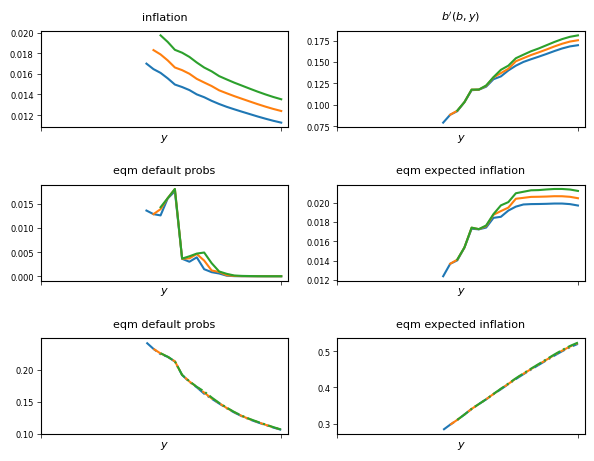

In [96]:
#= Slides Plot =#
fn=1

plot_slides(mp, ma, pe, pf, fignum=fn)

fs_base = 8
plot_style(
    fn, fs=fs_base, fs_legend=fs_base, fs_label=fs_base, format_tick_labels=false,  
    yticklabsize=fs_base-2, xticklabsize=fs_base-2, tick_direction="out", tick_pad=2, 
    tick_width=0.5, tick_length=3, hl=2, legend_loc=0, xlabel_coords=(0.5, -0.05), 
    ylabel_coords=(-0.05,0.5), title_coords=(0.5,1.03))
subplots_adjust(left=0.1, right=0.95, top=0.94, bottom=0.1, wspace=0.2, hspace=0.6)

#=
The negative correlation remains there with long-term debt.
Debt becomes much less pro-cyclical, but introducing debt dilution makes the 
*debt burden* pro-cyclical, because when default spreads rise, debt prices fall 
and so does the value of stock of debt to be eventually reduced via inflation.
Hence inflation incentives fall (mechanically) when spreads rise :)
Mathematically, it is all driven by the behaviour of q in the debt burden expression
b [ λ + (1-λ)(κ+q) ].
=#

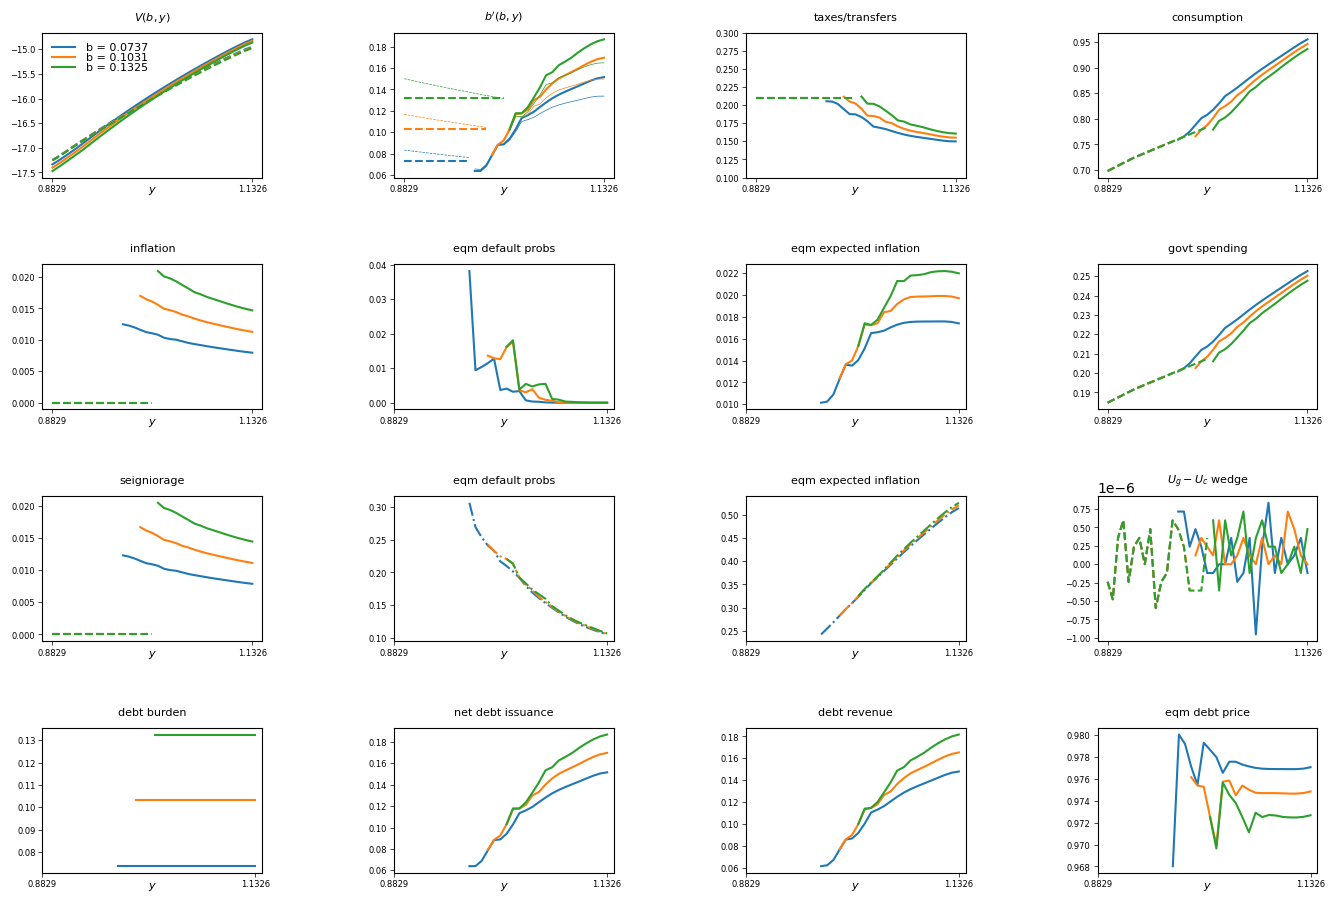

In [97]:
fn=1
figure(fn, figsize=(15,10))

plot_eqm_y(mp, ma, pe, pf, fignum=fn)

subplots_adjust(left=0.1, right=0.95, top=0.94, bottom=0.1, wspace=0.6, hspace=0.6)

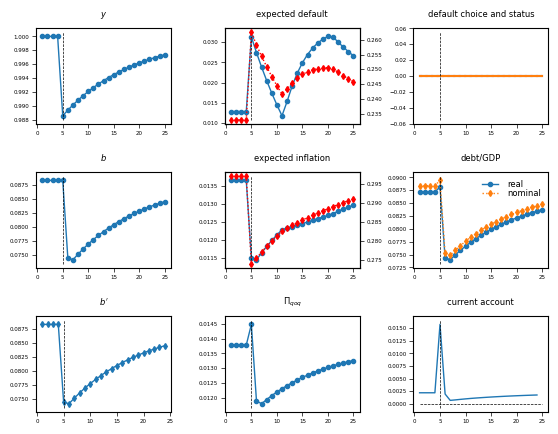

In [102]:
T_irf = 100
shocks = zeros(Float32, T_irf)
sa_irf, sp_irf = simulate_irf_itp(ma, shocks, b_init=0.05, default_length=10)
b_start = sa_irf.b_sim[end]

T_irf = 25
t_shock = 5
n_std_shock = 1
time_irf = 1:1:T_irf

shocks = zeros(Float32, T_irf)
shocks[t_shock] = -mp.σ_ϵ*n_std_shock
#shocks = ones(Float32, T_irf).*n_std_shock*(-mp.σ_ϵ)

sa_irf, sp_irf = simulate_irf_itp(
    ma, shocks, b_init=b_start, default_length=10
)

plot_irfs(sa_irf, sp_irf, fignum=7)

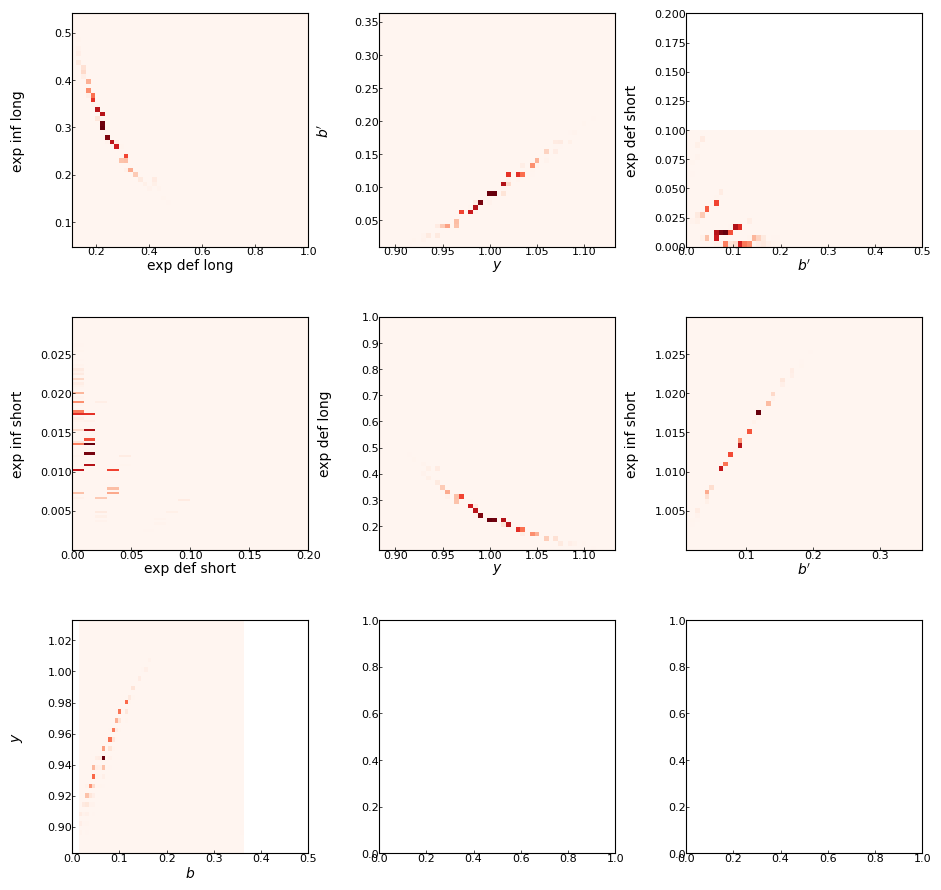

In [101]:
# Plot Scatterplot

fn=1
figure(fn, figsize=(10,10))

simulate_cg!(mp, ma, mat, pf, sa, sp);

T_end = mp.T_sim-100
    begin
        y_sim = Array(sa.y_sim[mp.T_discard_sim:T_end])
        b_sim = Array(sa.b_sim[mp.T_discard_sim:T_end])
        bprime_sim = Array(sa.b_sim[mp.T_discard_sim+1:T_end+1])
        # q_sim = Array(sa.q_sim[mp.T_discard_sim:T_end])
        # Π_qoq_sim = Array(sa.Π_qoq_sim[mp.T_discard_sim:T_end])
        # Π_yoy_sim = Array(sa.Π_yoy_sim[mp.T_discard_sim:T_end])
        def_status = Array(sa.def_status[mp.T_discard_sim:T_end])
        def_new = Array(sa.def_new)[mp.T_discard_sim:T_end]
        # c_sim = Array(sa.c_sim[mp.T_discard_sim:T_end])
        # g_sim = Array(sa.g_sim[mp.T_discard_sim:T_end])
        expdef_short_sim = Array(sp.expdef_short_sim[mp.T_discard_sim:T_end])
        expdef_long_sim = Array(sp.expdef_long_sim[mp.T_discard_sim:T_end])
        expinf_short_sim = Array(sp.expinf_short_sim[mp.T_discard_sim:T_end])
        expinf_long_sim = Array(sp.expinf_long_sim[mp.T_discard_sim:T_end])
    end

    T = length(y_sim)
    
    # Compute repay and default indicators (of length T_sim-T_discard)
    repind = @. def_status==false && def_new==false
    newdefind = @. def_status==false && def_new==true

    figure(fn)
    clf()
    rows = 3; cols = 3
    fig, axs = subplots(rows, cols, num=fn, clear=true)
    cm1 = PyPlot.cm.Reds;
    cm2 = PyPlot.cm.BuPu;
    b1 = (50, 50)

    sca(axs[1,1])
    hist2D(expdef_long_sim[repind], expinf_long_sim[repind].-1, cmap=cm1, bins=b1)
    xlabel("exp def long")
    ylabel("exp inf long")

    sca(axs[1,2])
    hist2D(y_sim[repind], bprime_sim[repind], cmap=cm1, bins=b1)
    xlabel(L"y")
    ylabel(L"b'")

    sca(axs[1,3])
    #hist2D(bprime_sim[repind], expdef_short_sim[repind], cmap=cm1, bins=b1)
    hist2D(bprime_sim[repind], expdef_short_sim[repind], cmap=cm1, bins=(0:0.01:0.5, 0:0.005:0.1))
    xlabel(L"b'")
    ylabel("exp def short")
    ylim(0,0.2)

    sca(axs[2,1])
    hist2D(expdef_short_sim[repind], expinf_short_sim[repind].-1, cmap=cm1, bins=(100,100))
    xlabel("exp def short")
    ylabel("exp inf short")
    xlim(0,0.2)

    sca(axs[2,2])
    hist2D(y_sim[repind], expdef_long_sim[repind], cmap=cm1, bins=b1)
    xlabel(L"y")
    ylabel("exp def long")

    sca(axs[2,3])
    hist2D(bprime_sim[repind], expinf_short_sim[repind], cmap=cm1, bins=b1)
    # hist2D(bprime_sim[repind], expinf_long_sim[repind].^(1/mp.T_longterm), cmap=cm2, bins=b1)
    xlabel(L"b'")
    ylabel("exp inf short")

    sca(axs[3,1])
    hist2D(b_sim[newdefind], y_sim[newdefind], cmap=cm1, bins=b1)
    xlabel(L"b")
    ylabel(L"y")
    xlim(0, 0.5)

    fs_base = 10
    plot_style(fn, fs=fs_base, fs_legend=fs_base, fs_label=fs_base, format_tick_labels=false,  yticklabsize=fs_base-2, xticklabsize=fs_base-2, tick_direction="in", tick_pad=0, tick_width=0.5, tick_length=2, hl=2, legend_loc=0, xlabel_coords=(0.5, -0.05), ylabel_coords=(-0.2,0.5), title_coords=(0.5,1.03))
    subplots_adjust(left=0.1, right=0.95, top=0.94, bottom=0.1, wspace=0.3, hspace=0.3)

# Constrained case - Short-term debt

In [143]:
# This works well with cyclicality and correlations but defprobs are too low
beta = 0.89; am = 36
κ_seign = 1.; τbar =  0.2
λ = 1.; κ = 0.
dtilde = 0.02; dratio_coeff = 0.4

begin
    yub = build_ModelArrays(build_ModelParams(nb=101, ny=35, gpu=false)).ygrid[end]
    dratio_ub = ((yub^2)*(1+dtilde)-yub)/(dtilde*(2*yub-1))
    dratio = dratio_ub*dratio_coeff
    d1 = dtilde*(dratio-yub)/(yub^2-yub)
    d0 = dtilde*(yub^2-dratio)/(yub^2-yub)

    mp_constrained = build_ModelParams(
        nb=101, ny=35, bgrid_lb=1e-2, bgrid_ub=0.5,
        σ_c=2., σ_g=2., g_lb=0., η=2.,
        β=beta, α_g=0.15, α_m=am, κ_seign=κ_seign, τbar=τbar,
        d0=d0, d1=d1, λ=1., κ=0., 
        ρ_B=1e-3, ρ_μ=1e-3, ρ_δ=1e-4,
        gpu=true
    )

    @time main_gpu(
        mp_constrained, max_iter=500, print_iter=50, sim_print="table", plot=0
    )
end

iter 50, error 6.2e-03
vfi ends with 86 iters, error 9.9e-05
┌──────────────────────────────┬────────────┬─────────┐
│                    statistic │ corr, mean │   stdev │
├──────────────────────────────┼────────────┼─────────┤
│         corr(cds, xcs) short │     0.1542 │         │
│          corr(cds, xcs) long │     0.6890 │         │
│                          ___ │            │         │
│                 corr(y, cds) │    -0.3261 │         │
│                 corr(y, xcs) │    -0.4651 │         │
│             corr(y, cpi_qoq) │    -0.3492 │         │
│               corr(cpi, cds) │     0.0388 │         │
│                   corr(y, b) │     0.8813 │         │
│                  corr(y, b') │     0.9400 │         │
│               corr(y, b-qb') │    -0.1169 │         │
│                          ___ │            │         │
│      taste error b (% of vr) │    1.0e-03 │         │
│     taste error mu (% of vd) │    2.9e-04 │         │
│ taste error default (% of v) │    0.0e+00

In [144]:
beta = 0.89; am = 36
κ_seign = 1.; τbar =  0.2
λ = 1.; κ = 0.
dtilde = 0.02; dratio_coeff = 0.4

begin
    yub = build_ModelArrays(build_ModelParams(nb=101, ny=35, gpu=false)).ygrid[end]
    dratio_ub = ((yub^2)*(1+dtilde)-yub)/(dtilde*(2*yub-1))
    dratio = dratio_ub*dratio_coeff
    d1 = dtilde*(dratio-yub)/(yub^2-yub)
    d0 = dtilde*(yub^2-dratio)/(yub^2-yub)

    mp_constrained = build_ModelParams(
        nb=101, ny=35, bgrid_lb=1e-2, bgrid_ub=0.5,
        σ_c=2., σ_g=2., g_lb=0., η=2.,
        β=beta, α_g=0.15, α_m=am, κ_seign=κ_seign, τbar=τbar,
        d0=d0, d1=d1, λ=1., κ=0., 
        ρ_B=1e-3, ρ_μ=1e-3, ρ_δ=1e-4,
        gpu=true
    )

    @time main_gpu(
        mp_constrained, max_iter=500, print_iter=50, sim_print="table", plot=0
    )
end

iter 50, error 7.2e-04
vfi ends with 63 iters, error 9.3e-05
┌──────────────────────────────┬────────────┬─────────┐
│                    statistic │ corr, mean │   stdev │
├──────────────────────────────┼────────────┼─────────┤
│         corr(cds, xcs) short │     0.0807 │         │
│          corr(cds, xcs) long │    -0.5331 │         │
│                          ___ │            │         │
│                 corr(y, cds) │     0.9475 │         │
│                 corr(y, xcs) │    -0.5050 │         │
│             corr(y, cpi_qoq) │    -0.3383 │         │
│               corr(cpi, cds) │    -0.3474 │         │
│                   corr(y, b) │     0.7952 │         │
│                  corr(y, b') │     0.8524 │         │
│               corr(y, b-qb') │    -0.0825 │         │
│                          ___ │            │         │
│      taste error b (% of vr) │    1.2e-03 │         │
│     taste error mu (% of vd) │    8.1e-03 │         │
│ taste error default (% of v) │    0.0e+00

# Constrained case - Long-term debt

In [41]:
beta = 0.97
am = 36
κ_seign = 1.
τbar =  0.2
λ = 0.0568
κ = 0.0063

dtilde = 0.02
dratio_coeff = 0.45

begin
    yub = build_ModelArrays(build_ModelParams(nb=101, ny=35, gpu=false)).ygrid[end]
    dratio_ub = ((yub^2)*(1+dtilde)-yub)/(dtilde*(2*yub-1))
    dratio = dratio_ub*dratio_coeff
    d1 = dtilde*(dratio-yub)/(yub^2-yub)
    d0 = dtilde*(yub^2-dratio)/(yub^2-yub)

    mp_constrained = build_ModelParams(
        nb=101, ny=35, bgrid_lb=1e-2, bgrid_ub=0.5,
        σ_c=2., σ_g=2., g_lb=0., η=2.,
        β=beta, α_g=0.15, α_m=am, κ_seign=κ_seign, τbar=τbar,
        d0=d0, d1=d1, λ=λ, κ=κ, 
        ρ_B=1e-3, ρ_μ=5e-3, ρ_δ=1e-4,
        gpu=true
    )

    @time main_gpu(
        mp_constrained, max_iter=500, print_iter=50, sim_print="table", plot=0
    )
end

iter 50, error 4.4e-01
iter 100, error 9.6e-02
iter 150, error 2.1e-02
iter 200, error 4.6e-03
iter 250, error 1.0e-03
iter 300, error 2.4e-04
vfi ends with 331 iters, error 9.9e-05
┌──────────────────────────────┬────────────┬─────────┐
│                    statistic │ corr, mean │   stdev │
├──────────────────────────────┼────────────┼─────────┤
│         corr(cds, xcs) short │    3.5e-03 │         │
│          corr(cds, xcs) long │     0.8979 │         │
│                          ___ │            │         │
│                 corr(y, cds) │    -0.2438 │         │
│                 corr(y, xcs) │    -0.1871 │         │
│             corr(y, cpi_qoq) │    -0.1858 │         │
│               corr(cpi, cds) │    -0.2540 │         │
│                   corr(y, b) │     0.7314 │         │
│                  corr(y, b') │     0.6562 │         │
│               corr(y, b-qb') │    -0.0185 │         │
│                          ___ │            │         │
│      taste error b (% of vr) │  

# Plots - Constrained case

In [66]:
mp, ma, mat, pe, pf, sa, sp = main_gpu(
    mp_constrained, max_iter=500, print_iter=50, sim_print="table", ret_arrays=true
);

simulate_cg!(mp, ma, mat, pf, sa, sp)

iter 50, error 6.2e-03
vfi ends with 86 iters, error 9.9e-05
┌──────────────────────────────┬────────────┬─────────┐
│                    statistic │ corr, mean │   stdev │
├──────────────────────────────┼────────────┼─────────┤
│         corr(cds, xcs) short │     0.1542 │         │
│          corr(cds, xcs) long │     0.6890 │         │
│                          ___ │            │         │
│                 corr(y, cds) │    -0.3261 │         │
│                 corr(y, xcs) │    -0.4651 │         │
│             corr(y, cpi_qoq) │    -0.3492 │         │
│               corr(cpi, cds) │     0.0388 │         │
│                   corr(y, b) │     0.8813 │         │
│                  corr(y, b') │     0.9400 │         │
│               corr(y, b-qb') │    -0.1169 │         │
│                          ___ │            │         │
│      taste error b (% of vr) │    1.0e-03 │         │
│     taste error mu (% of vd) │    2.9e-04 │         │
│ taste error default (% of v) │    0.0e+00

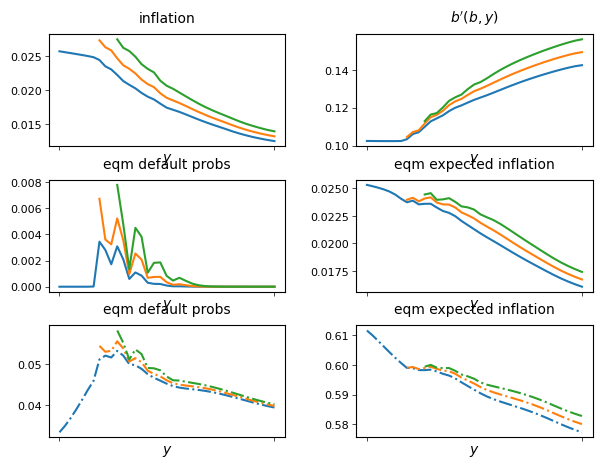

In [63]:
plot_slides(mp, ma, pe, pf)

In [ ]:
#= Slides Plot =#
fignum = 1

begin
    bgrid = convert(Array, ma.bgrid)
    ygrid = convert(Array, ma.ygrid)
    bprime_rep = convert(Array, ma.bprime_rep)
    Π_rep = convert(Array, ma.Π_rep)
    Π_def = convert(Array, ma.Π_def)
    def_policy = convert(Array, ma.def_policy)
    expdef_short_eqm_rep = convert(Array, pe.expdef_short_eqm_rep)
    expinf_short_eqm_rep = convert(Array, pe.expinf_short_eqm_rep)
    expdef_long_eqm_rep = convert(Array, pe.expdef_long_eqm_rep)
    expinf_long_eqm_rep = convert(Array, pe.expinf_long_eqm_rep)
end

figure(fignum)
clf()
rows=3; cols=3
fig, axs = subplots(rows, cols, num=fignum, clear=true)

b_mean = 0.12
b_std = 0.02
# ibs = [searchsortedfirst(bgrid, b_mean+b_std*j) for j in -1:0.5:0]
ibs = [searchsortedfirst(bgrid, b_mean+b_std*j) for j in -2:2:2]

for ib in ibs
    b=bgrid[ib]

    def_threshold = 0.5
    defind = def_policy[ib,:] .> def_threshold
    repind = def_policy[ib,:] .<= def_threshold

    sca(axs[1,1]); title("inflation")
    l1,=plot(ygrid[repind], Π_rep[ib,repind].-1, "-", label = @sprintf("b = %.2f", b))
    c=l1.get_color()
    plot(ygrid[defind], Π_def[ib,defind].-1, "--",color=c)
    xlabel(L"y")

    sca(axs[1,2]); title(L"b'(b, y)")
    plot(ygrid[repind], bprime_rep[ib,repind], "-",color=c)
    xlabel(L"y")

    sca(axs[1,3]); title(L"\delta(b, y)")
    plot(ygrid, def_policy[ib,:], "-",color=c)
    ylim(-0.05, 1.05)
    xlabel(L"y")

    sca(axs[2,1]); title("eqm default probs")
    plot(ygrid[repind], expdef_short_eqm_rep[ib,repind],"-",color=c)
    xlabel(L"y")

    sca(axs[2,2]); title("eqm expected inflation")
    plot(ygrid[repind], expinf_short_eqm_rep[ib,repind].-1,"-",color=c)
    xlabel(L"y")

    sca(axs[3,1]); title("eqm default probs")
    plot(ygrid[repind], expdef_long_eqm_rep[ib,repind],"-.",color=c)
    xlabel(L"y")
    
    sca(axs[3,2]); title("eqm expected inflation")
    plot(ygrid[repind], expinf_long_eqm_rep[ib,repind].-1,"-.",color=c)
    xlabel(L"y")
end

for i in 1:rows*cols
    sca(axs[i])
    xticks([ygrid[1], ygrid[end]], [])
end

fs_base = 8
plot_style(
    fn, fs=fs_base, fs_legend=fs_base, fs_label=fs_base, format_tick_labels=false,  
    yticklabsize=fs_base-2, xticklabsize=fs_base-2, tick_direction="out", tick_pad=2, 
    tick_width=0.5, tick_length=3, hl=2, legend_loc=0, xlabel_coords=(0.5, -0.05), 
    ylabel_coords=(-0.05,0.5), title_coords=(0.5,1.03))
subplots_adjust(left=0.1, right=0.95, top=0.94, bottom=0.1, wspace=0.2, hspace=0.6)

In [ ]:
plot_eqm_b(mp, ma, pe, pf)

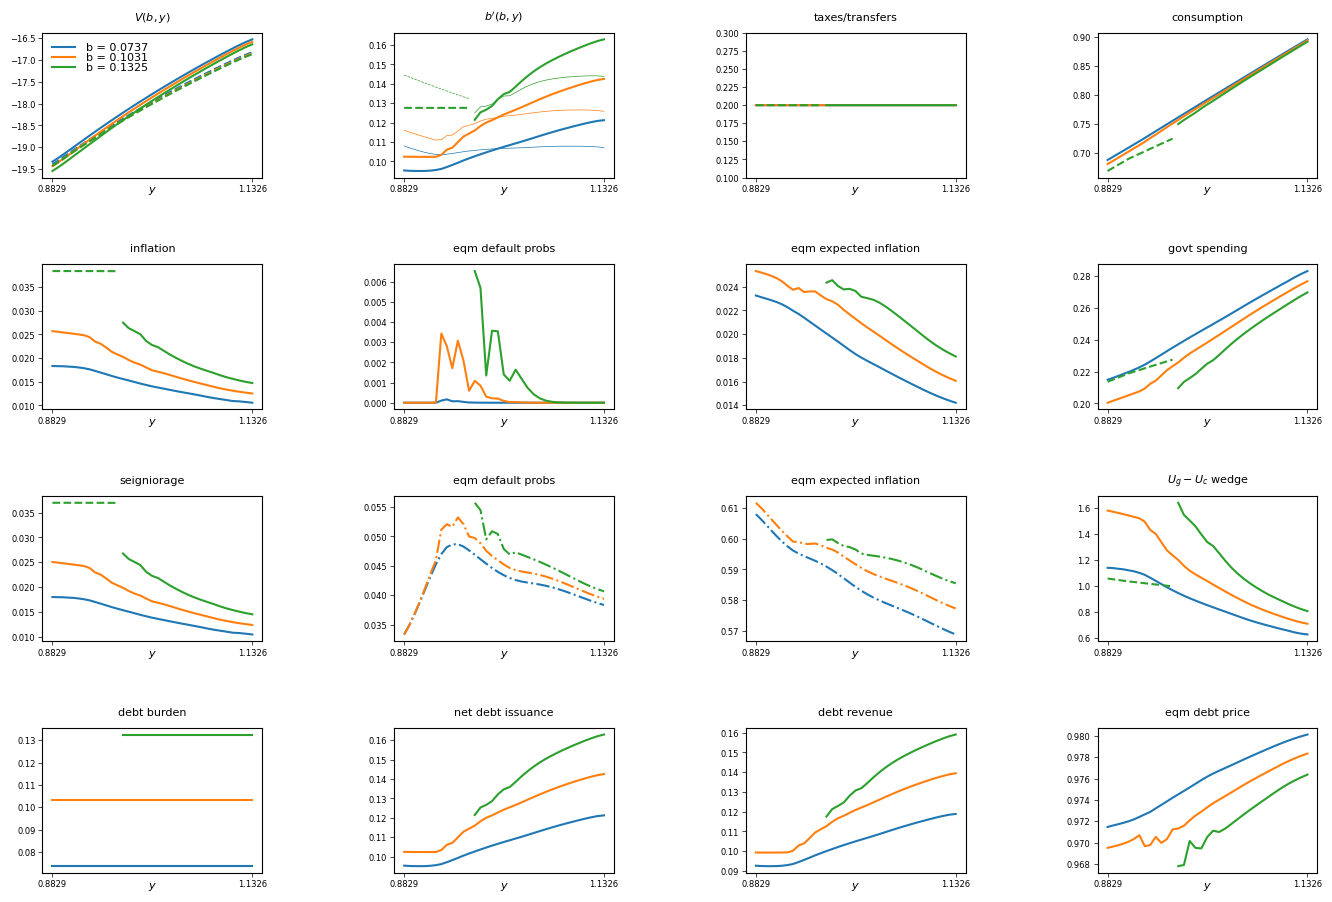

In [58]:
fn=1
figure(fn, figsize=(15,10))

plot_eqm_y(mp, ma, pe, pf, fignum=fn)

subplots_adjust(left=0.1, right=0.95, top=0.94, bottom=0.1, wspace=0.6, hspace=0.6)

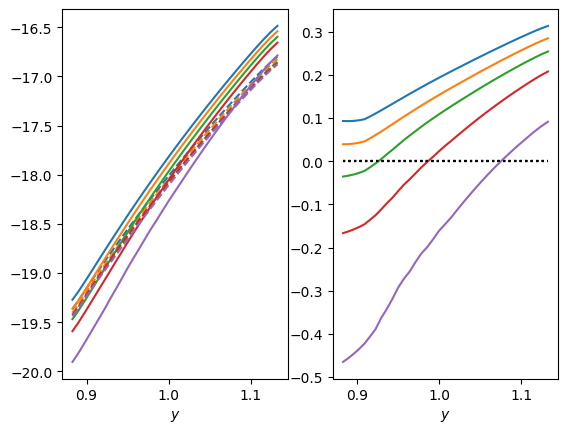

In [59]:
bgrid = convert(Array, ma.bgrid)
ygrid = convert(Array, ma.ygrid)
vr = convert(Array, ma.vr)
vd = convert(Array, ma.vd)

rows=1; cols=2
fig, axs = subplots(rows, cols, num=fignum, clear=true)

ibs = [searchsortedfirst(bgrid, x) for x in [0.05; 0.08; 0.11; 0.14; 0.2]]

for ib in ibs
    b=bgrid[ib]
    sca(axs[1])
    l1,=plot(ygrid, vr[ib,:], "-", label = @sprintf("b = %.2f", b))
    c=l1.get_color()
    plot(ygrid, vd[ib,:], "--",color=c)
    xlabel(L"y")

    sca(axs[2])
    plot(ygrid, vr[ib,:].-vd[ib,:], "-",color=c)
    plot(ygrid, zeros(mp.ny), ":k")
    xlabel(L"y")
end

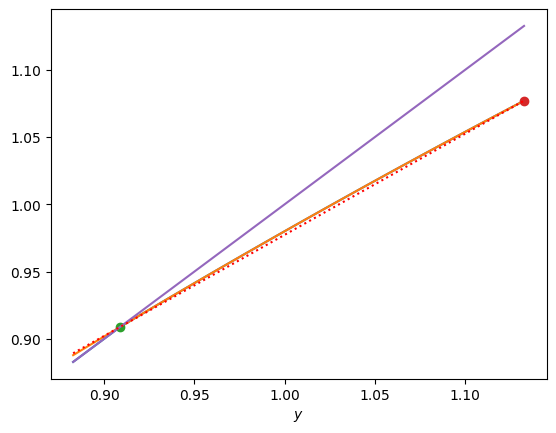

PyObject Text(0.5, 25.0, '$y$')

In [60]:
d0, d1
ylb = ygrid[1]
yub = ygrid[end]
#d0*ylb+d1*ylb^2

y1 = -d0/d1
y2 = yub-max(0,d0*yub+d1*yub^2)

coef = (y2-y1)/(yub-y1)
interc = y1-coef*y1

figure()
plot(ygrid, [y-max(0,d0*y+d1*y^2) for y in ygrid])
plot(ygrid, [y-d0*y-d1*y^2 for y in ygrid])
plot(y1, y1, "o")
plot(yub, yub-max(0,d0*yub+d1*yub^2), "o")
plot(ygrid, ygrid)
plot(ygrid, [coef*y+interc for y in ygrid], ":r")
xlabel(L"y")

In [ ]:
plot_histograms(sa, sp)

In [ ]:

plot_scatters(sa, sp, fignum=1)

fs_base = 10
plot_style(
    fn, fs=fs_base, fs_legend=fs_base, fs_label=fs_base, format_tick_labels=false,  
    yticklabsize=fs_base-2, xticklabsize=fs_base-2, tick_direction="out", tick_pad=2, 
    tick_width=0.5, tick_length=3, hl=2, legend_loc=0, xlabel_coords=(0.5, -0.05), 
    ylabel_coords=(-0.05,0.5), title_coords=(0.5,1.03))
subplots_adjust(left=0.1, right=0.95, top=0.94, bottom=0.1, wspace=0.2, hspace=0.6)

In [ ]:
plot(bgrid, [sum(def_policy[ib, :])/mp.ny for ib in 1:mp.nb], "-o")

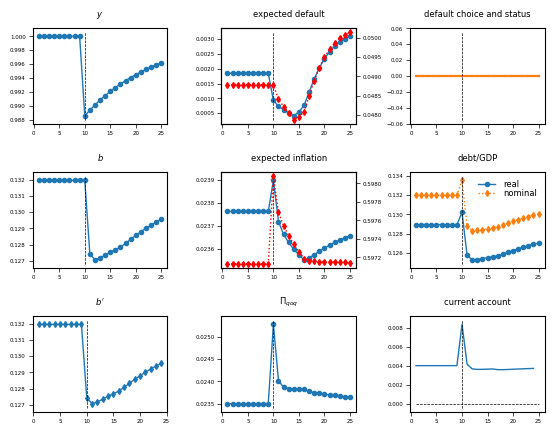

In [67]:
y_start = 1.

T_irf = 100
shocks = zeros(Float32, T_irf)
sa_irf, sp_irf = simulate_irf_itp(ma, shocks, y_init=y_start, b_init=0.05, default_length=10)
b_start = sa_irf.b_sim[end]

T_irf = 25
t_shock = 10
n_std_shock = 1
time_irf = 1:1:T_irf

shocks = zeros(Float32, T_irf)
shocks[t_shock] = -mp.σ_ϵ*n_std_shock
#shocks = ones(Float32, T_irf).*n_std_shock*(-mp.σ_ϵ)

sa_irf, sp_irf = simulate_irf_itp(
    ma, shocks, y_init=y_start, b_init=b_start, default_length=10
)

plot_irfs(sa_irf, sp_irf, fignum=7)

# Debugging

In [ ]:
taste_error_δ = mean(
        @. log(ma.vd/max(ma.vr,ma.vd)) + log(ma.vr/ma.vd)*1/(1+exp((ma.vd-ma.vr)/mp.ρ_δ))
    )

-2.0658415f-10

In [ ]:
mean(@. (ma.vr + 1/(1+exp((ma.vd-ma.vr)/mp.ρ_δ)) * (ma.vd-ma.vr))/max(ma.vr,ma.vd)-1)

0.009700916f0

In [ ]:
mean(@. (ma.vr + ma.def_policy * (ma.vd-ma.vr))/max(ma.vr,ma.vd))-1

0.0f0

In [ ]:
mean(@. ((1-ma.def_policy)*ma.vr + ma.def_policy*ma.vd)/max(ma.vr,ma.vd)-1)

0.0f0

In [ ]:
def_policy = convert(Array{Float64}, ma.def_policy)
bgrid = convert(Array{Float64}, ma.bgrid)
ygrid = convert(Array{Float64}, ma.ygrid)

figure(1)
ib1 = searchsortedfirst(bgrid, 0.01)
ib2 = searchsortedfirst(bgrid, 0.2)
@show ib1, ib2
#hist(def_policy[ib1:ib2,:], bins=collect(0:0.05:1));

(ib1, ib2) = (2, 40)
